# Analysing Tidal Disruption Event Dust Echoes
#### This notebook shows the capabilities of the modified SKIRT code in creating simulations of Tidal Disruption Event Dust Echoes. <br>
The notebook consists of a section where the initial parameters are loaded, then a section that performs a single run, and another section that varies a parameter to find its influence on the output. <br>

Our version of the TDE dust echo simulations can give lightcurves on any wavelength, but  contains a function to take the transmission curve of the WISE W1 and W2 wavelengths into account (other filters can easily be added if necessary). These can also be compared to existing data of the sources. <br>
It also returns the spectrum of simulations, on any wanted wavelength range and resolution. These spectra are then used for temperature analysis. <br> 
The simulated (W1-W2) color-time diagrams are also shown and compared to WISE data. <br>

Our data_analysis class performs all these functions on its own, though it cannot perform simulations. The class is still fairly bare-bones.<br>

**Original by Remon van Gaalen,** *https://github.com/vgaalen/DustEcho* <br>
**Edited and expanded upon by Pepijn Lankhorst & Leon Schoof,** *https://github.com/piepain/TDustEchoes*

In [17]:
import os,sys
sys.path.append('./PTS')

import numpy as np

from astropy import units as u
from astropy import constants as c
from astropy.io import ascii
from astropy.time import TimeDelta 
from astropy.time import Time
from astropy.modeling.models import BlackBody

from scipy import optimize as opt
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import datetime
import json
from utils import *

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
%matplotlib inline

from run_skirt import get_lightcurve

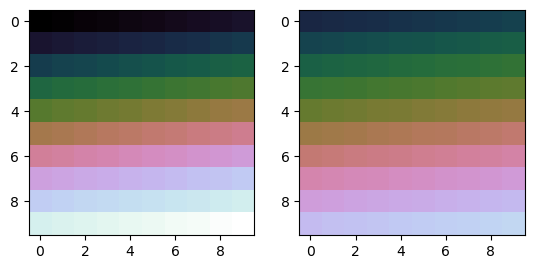

In [2]:
#Loading colormap
thesis_cmap = truncate_colormap(plt.get_cmap('cubehelix'), 0.15, 0.83)

#Showing the difference between the colormaps
arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(arr, interpolation='nearest', cmap='cubehelix')
ax[1].imshow(arr, interpolation='nearest', cmap=thesis_cmap)
plt.show()

W1_col, W2_col, UV_col, UV_col_light, diff_col = '#ff7356','#681b20','#234787', '#4aa0ad', '#932d7e'

# Defining necessary variables

### Defining target and making folders

In [3]:
target = 'AT2019qiz'
distance = 65.6*u.Mpc # 1171 Mpc for ASASSN-15lh, 65.6 Mpc for AT2019qiz

today = str(datetime.date.today())
starttime = datetime.datetime.now().strftime('%H%M')
suffix = '' # Possibility to add a suffix to prevent any problems with permissions in shared folders.


OUTFILES = "results/"+target+'/'+today+suffix+'/'+starttime+'/'
PLOTFILES = "plots/"+target+'/'+today+suffix+'/'+starttime+'/'
DATAFILES = "data/"+target+'/'

if os.path.isdir(DATAFILES) == False:
    os.makedirs(DATAFILES[:-1])
if os.path.isdir(OUTFILES) == False:
    os.makedirs(OUTFILES[:-1])
if os.path.isdir(PLOTFILES) == False:
    os.makedirs(PLOTFILES[:-1])

### Defining simulation parameters

In [4]:
# Define Simulation Parameters
timesteps = 10                              # amount of timesteps considered by SKIRT
output_tsteps = 100                         # desired amount of timesteps after interpolation

amin_C,amin_Si = 0.005,0.005                # smallest dust grain size in micron, 1e-4 is the lowest value supported by SKIRT, 0.005 from paper with opacity
amax_C, amax_Si = 0.1,0.1                   # largest dust grain size in micron
grainpowerlaw_C, grainpowerlaw_Si = 2.5,2.5 # the powerlaw distribution of mass along different grain sizes
nsizes = 15                                 # Number of dust sizes

normalization_type = 'optical_depth'        # Define the normalisation method of SKIRT. Either 'mass' or 'optical_depth'

opt_depth = 10                              # Optical depth of dust structure
axis = 'Z'                                  # Axis along which to measure the optical depth (For a sphere this does not matter due to symmetry)
wl_opt_depth = 0.28                         # Wavelength at which to measure optical depth

total_mass = 1                              # Total mass of the dust geometry in solar masses

Si = 0.                                     # silicates fraction (as opposed to graphites)

inner = 0.1                                 # the dust shell's inner radius in pc
outer = 0.15                                # outer radius of the dust shell in pc
alpha = 1                                   # radial dust mass density powerlaw
spaceBins = 10                              # number of spatial shells in the radial direction

nphotons = 1e6                              # Number of photon packets used in SKIRT simulation

static = True                               # Sublimation on (static=False) or off (static=True)

T = 2e4                                     # Temperature of the blackbody in the simulation. We use a constant termperature as the dataset does not provide a very accurate read on the temperature.
wl_w1,wl_w2 = 3.368*u.um, 4.618*u.um        # Central wavelengths of WISE's W1 and W2 filters
bbwl = np.array([0.29*1e4/(T)])             #From Wiens law: wavelength at which the black body peaks

w1w2 = np.array([wl_w1.value,wl_w2.value])
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 2), np.linspace(1.01, 10, 80), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl))) #Output wavelengths for SKIRT
relBinwidth = 0.0001                        # Relative binwidth for the output wavelengths

skiname = 'SKI/TDE_ski.txt'                 # Name of the .ski file to be used for the simulation

### Loading lightcurve data and defining SKIRT input data

In [5]:
# Define filters, filter names, and the day of the UV peak
_, filters, SWIFT_freq, mjd0 = get_lightcurve_data(tde_name=target, datafolder=DATAFILES)
# Load the TDE lightcurve
L = data_luminosity(tde_name = target, datafolder = DATAFILES, distance=distance) #nu_Lnu of the data
WISE_data =ascii.read(DATAFILES+target+'_neoWISE_diffphoto.dat',format='fixed_width')
W1 = np.array([WISE_data['mjd']-mjd0,FluxtoLum(WISE_data['w1_flux_Jy']*u.Jy,distance=distance),FluxtoLum(WISE_data['w1_flux_Jy_err']*u.Jy,distance=distance)])
W2 = np.array([WISE_data['mjd']-mjd0,FluxtoLum(WISE_data['w2_flux_Jy']*u.Jy,distance=distance),FluxtoLum(WISE_data['w2_flux_Jy_err']*u.Jy,distance=distance)])

W1_filtered = W1[:, W1[0]>0]
WISEcolor = np.array(WISE_data['w1_vegamag']-WISE_data['w2_vegamag'])[W1[0]>0]
WISEcolor_err = np.array(np.sqrt(WISE_data['w1_mag_err']**2 + WISE_data['w2_mag_err']**2 ))[W1[0]>0]

# Sorting the data based on time, and cutting the data from before the peak
# Also removing non-UV data
UV = []
UVfilters = []
for filter in range(len(filters)):
    if 'UV' in filters[filter]:
        UV.append(SWIFT_freq[filter])
        UVfilters.append(filters[filter])
UVmask = np.isin(L[3], UV)
L_filtered = [sub_array[UVmask] for sub_array in L]

time_mask = L_filtered[0] > 0
L_filtered = [sub_array[time_mask] for sub_array in L_filtered]
sorted_indices = L_filtered[0].argsort()

# Reduce the amount of timesteps to 'timesteps', with a number of them concentrated close to the peak
# if timesteps is increased, users might want to omit this
t_data=np.concatenate(([np.min(L_filtered[0]),np.sort(L_filtered[0])[1],np.sort(L_filtered[0])[2],np.min(L_filtered[0])+20],\
                       np.linspace(np.min(L_filtered[0])+40,np.max(L_filtered[0]),timesteps-3)))
L_data=binning(t_data,L_filtered[0],L_filtered[1],L_filtered[2])
t_data=L_data[0]

# To find the bolometric luminosity correction factor, compare the surface beneath the luminosity 
# of a blackbody with temperature 2e4 K to the nu*L_nu of that same blackbody at the SWIFT frequencies.
# Integrate the function over a large, finite range that includes almost all blackbody's emission
Lbol, err = quad(blackbody_Lnu,0.1,1e18)
Lbol_factor = np.array([Lbol/(blackbody_Lnu(i)*i) for i in L[3]])

# Binning the correction factor in the same way as the data earlier to use in SKIRT input
tbol_data=np.concatenate(([np.min(L_filtered[0]),np.sort(L_filtered[0])[1],np.sort(L_filtered[0])[2],np.min(L_filtered[0])+20],\
                       np.linspace(np.min(L_filtered[0])+40,np.max(L_filtered[0]),timesteps-3)))
Lbol_data=binning(tbol_data,L[0],L[1]*Lbol_factor,L[2]*Lbol_factor,clean=False)
tbol_data = Lbol_data[0]

T_data = np.array((Lbol_data[0],[T]*len(Lbol_data[2]))) # Making an array of the temperature

output_t = np.linspace(np.min(t_data),np.max(t_data)+0.3*(np.max(t_data)-np.min(t_data)),output_tsteps) # Defining the output times in MjD after peak

/usr/lib64/python3.12/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.12/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/lib64/python3.12/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib64/python3.12/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/lib64/python3.12/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:351: RuntimeWarning: overflow encountered in expm1
  exponent = np.expm1((c.h * frequency / (c.k_B * T)).to_value(''))


### Plotting the input data
We plot the WISE dust echo data and the SWIFT UV/optical light curve. <br>
The simulation will use the navy-blue points as an input lightcurve. These were obtained by binning the SWIFT lightcurve (as seen above).

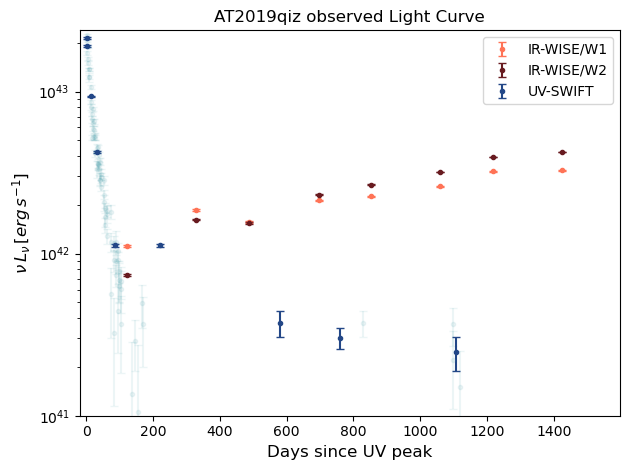

In [6]:
# Plotting the input data
plt.figure()
plt.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=np.abs((c.c/wl_w1).to(u.Hz).value*W1[2]),\
             fmt='.',capsize=3,color=W1_col,label='IR-WISE/W1')
plt.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=np.abs((c.c/wl_w2).to(u.Hz).value*W2[2]),\
             fmt='.',capsize=3,color=W2_col,label='IR-WISE/W2')
plt.errorbar(L_filtered[0],L_filtered[1],yerr=L_filtered[2],fmt='.',alpha=0.1,capsize=3,color=UV_col_light)
plt.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color=UV_col,capsize=3,label='UV-SWIFT')
plt.xlabel('Days since UV peak',fontsize=12)
plt.ylabel(r"$\nu\,L_{\nu}\,[erg\,s^{-1}]$",fontsize=12)
plt.title(target+' observed Light Curve')
plt.xlim(-20)
plt.ylim(1e41)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(OUTFILES+target+'_lightcurve.pdf')
plt.show()

### Finding the FWHM (if not static)
As this implementation cannot track dust survival time, the dust sublimation is based on the light curve's FWHM. <br>
Here, we find the FWHM by fitting a gaussian. <br>
**This should be checked for new sources**, to see if the second fit is necessary, or adjust parameters.

In [7]:
if static:
    FWHM = 0 # If we do not take sublimation into account, the FWHM is not needed.
elif not static:
    N = len(L[0,:])
    X = L[0,:]
    Y = L[1,:]
    
    p0 = [L[0,np.argmax(L[1,:])],100] # Inital guess is a normal distribution
    errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
    p1, success = opt.leastsq(errfunc, p0[:], args=(X, Y))
    fit_mu, fit_stdev = p1
    FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev
    print("FWHM", FWHM)
    
    # Plot to verify the fit
    plt.figure()
    plt.scatter(X,Y,s=0.1,color=UV_col,label='Data')
    fit=gauss(X,p1)
    plt.scatter(X, np.max(Y)/np.max(fit) * fit,s=0.5, color='r',label='Gaussian Fit')
    plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='g', alpha=0.3,label='FWHM')
    plt.xlim(0,700)
    plt.legend()
    plt.savefig(OUTFILES+'FWHM.pdf')
    plt.show()
    
    # Looking at the first plot shows that the second peak in 15lh's lightcurve is dictating the FWHM
    # As this is undesirable, we will not use this part for the fit
    
    mask = (L[0]<90)
    N = len(L[0,mask])
    X = L[0,mask]
    Y = L[1,mask]
    
    p0 = [L[0,np.argmax(L[1,:])],L[0,np.argmin(np.abs(L[1]-0.5*np.max(L[1])))]-L[0,np.argmax(L[1,:])]] # Inital guess is a normal distribution
    errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
    p1, success = opt.leastsq(errfunc, p0[:], args=(X, Y))
    fit_mu, fit_stdev = p1
    FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev 
    print("FWHM", FWHM)
    
    # Plot to verify the fit
    plt.figure()
    plt.scatter(X,Y,s=1,c=UV_col,label='Data')
    fit=gauss(X,p1)
    plt.scatter(X, np.max(Y)/np.max(fit) * fit,s=1, color='r',label='Gaussian Fit')
    plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='g', alpha=0.3,label='FWHM')
    plt.axvline(fit_mu+FWHM/2, linestyle='dashed',color='g')
    plt.xlim(0,100)
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTFILES+'FWHM.pdf')
    plt.show()

### Making a convolution to mimick a transfer function
We make a convolution of the incoming (UV/Optical) lightcurve and a step-function to show the result of a radiative transfer function. This allows us to see the effect of the inner radius on the dust echo lightcurve.

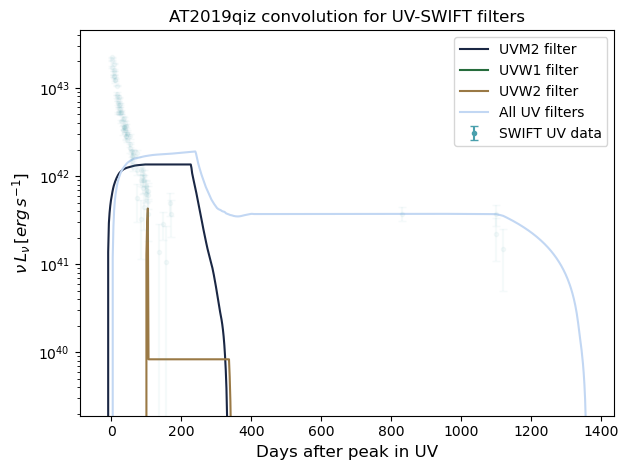

In [8]:
# Plotting for each of the separate filters
for i in range(len(UVfilters)):
    color = thesis_cmap(i/(len(UVfilters)+1)) #Get the color from the colormap
    time_range, lum_data = L[0][np.argwhere(L_filtered[3]==UV[i])] , L_filtered[1][np.argwhere(L_filtered[3]==UV[i])]
    lc_conv_time, lc_conv_lum = convolution(inner,lum_data,time_range)
    plt.plot(lc_conv_time,lc_conv_lum,label = f'{UVfilters[i].replace(".uvot","").replace(".ztf","")} filter',color=color)

# Plotting for all filters
lc_conv_time,lc_conv_lum = convolution(inner,L_filtered[1][sorted_indices],L_filtered[0][sorted_indices])
plt.plot(lc_conv_time,lc_conv_lum,label = 'All UV filters',color=thesis_cmap(i+1/(len(UVfilters)+1))) 
plt.title(target+" convolution for UV-SWIFT filters")
plt.errorbar(L_filtered[0],L_filtered[1], yerr=L_filtered[2], fmt='.', alpha=0.05, capsize=3, color = UV_col_light)
plt.errorbar(0,0,0, fmt='.', capsize=3,color=UV_col_light, label='SWIFT UV data')
plt.yscale('log')
plt.ylim(np.max(lc_conv_lum)/1e3)
#plt.axvline(x= L[0][sorted_indices[0]]+ 2* rinner_days,linestyle = '--', label = "2R/c", alpha = 0.5, color = 'red')
plt.xlabel('Days after peak in UV',fontsize=12)
plt.ylabel(r"$\nu\,L_{\nu}\,[erg\,s^{-1}]$",fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig(OUTFILES+target+"_filterconv.pdf")
plt.show()

# Running the simulations
Here we run the SKIRT simulations through python. <br>
Some notes on these simulations can be found in the collapsible cell below.

### Notes

#### Main limitations
**Non-static optical depth normalization** <br>
Simulations with sublimation on (static=False) do not support optical depth normalization. <br>
This can be circumvented by finishing one run within a static optical depth normalization simulation, stopping the run, and looking at one of the convergence.dat files found within the results. Here you can find the mass SKIRT used for the run. You can take this mass to start a run with sublimation at the desired optical depth.
#### Notes
**Difference in grain size distribution with and without sublimation** <br>
Due to the way the sublimation is handled, we have to use multiple layers of dust, each with only one grain size. <br>
This differs from the powerlaw grain size distribution that is built in to SKIRT. This means that there is an inherent (small) difference between the results. <br>
**'Error' in static simulations** <br>
When doing a run without sublimation, SKIRT will show the following error message: <br>
`Error: Cannot destroy dust for fragmented dust mix without dynamic densities` <br>
This error shows because we have set the dynamic density to false to ensure that no dust is destroyed. This error does not affect the run in any way, other than not being able to destroy dust which is exactly what we want for a static simulation.<br>
**Single grain size simulation** <br>
When performing a simulation with nsizes=1, the amin_C and amin_Si will be used for this grainsize. The other parameters within the grain array will not be used for the simulations, but please make sure to leave them there as placeholders.

## A single run

In [12]:
# Saving to a specific folder within the results
OUTFILES_ = OUTFILES+'1run_'+normalization_type+'/'
PLOTFILES_ = PLOTFILES+'1run_'+normalization_type+'/'

if os.path.isdir(OUTFILES_) == False:
    os.makedirs(OUTFILES_[:-1])
if os.path.isdir(PLOTFILES_) == False:
    os.makedirs(PLOTFILES_[:-1])

# Starting the simulation
lightcurve,wavelength,temp,radius,simulation = get_lightcurve(np.array((Lbol_data[0],Lbol_data[1] \
                                                                         ,Lbol_data[2])) \
                                                               ,T_data, tbol_data, output_t, np.append(output_wavelengths,relBinwidth) \
                                                               ,[inner,outer,alpha] \
                                                               ,[[amin_C,amax_C,grainpowerlaw_C],[amin_Si,amax_Si,grainpowerlaw_Si]], spaceBins \
                                                               ,normalization_type=normalization_type \
                                                               ,total_mass = total_mass, opt_depth = [opt_depth,wl_opt_depth,axis], nsizes=nsizes \
                                                               ,static=static,FWHM=FWHM, nphotons=nphotons \
                                                               ,distance=distance,skiname=skiname, Si=Si \
                                                               ,prefix=str(today), OUTFILES=OUTFILES_, SKIRTpath='SKIRT/release/SKIRT/main/skirt',suffix=suffix)

Now simulating the lightcurve for a sphere with 15 dust grain sizes, optical depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

14/06/2024 17:36:05.772   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 17:36:05.772   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 17:36:05.773   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/1run_optical_depth/2/run.ski'...
14/06/2024 17:36:12.832 - Finished setup in 6.9 s.
14/06/2024 17:36:13.153 - Finished setup output in 0.3 s.
14/06/2024 17:36:13.164 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 17:36:13.164 - Finished primary emission iteration 1 in 0.0 s.
14/06/2024 17:36:13.181 - Finished primary emission in 0.0 s.
14/06/2024 17:36:13.208 - Finished secondary emission iteration 1 in 0.0 s.
14/06/2024 17:36:13.233 - Finished secondary emission iteration 2 in 0.0 s.
14/06/2024 17:36:13.263 - Finished secondary emission iteration 3 in 0.0 s.
14/06/2024 17:36:13.292 - Finished secondary emission iteration 4 

SKIRT Runs:  10%|███▏                            | 1/10 [00:09<01:22,  9.19s/it]

14/06/2024 17:36:14.855 - Finished final output in 1.4 s.
14/06/2024 17:36:14.855 * *** Error: The following error message was issued during this simulation:
14/06/2024 17:36:14.855 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 17:36:14.855 - Finished simulation run using 6 threads and a single process in 8.9 s.
14/06/2024 17:36:14.865   Available memory: 15.4 GB -- Peak memory usage: 230 MB (1.5%)
14/06/2024 17:36:14.998   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 17:36:14.998   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 17:36:15.000   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/1run_optical_depth/2/run.ski'...
14/06/2024 17:36:21.957 - Finished setup in 6.8 s.
14/06/2024 17:36:22.362 - Finished setup output in 0.4 s.
14/06/2024 17:36:22.411 * *** Error: Cannot destroy dust for fragmented dust mix with

SKIRT Runs:  20%|██████▍                         | 2/10 [00:18<01:13,  9.17s/it]

14/06/2024 17:36:24.014 - Finished final output in 1.4 s.
14/06/2024 17:36:24.014 * *** Error: The following error message was issued during this simulation:
14/06/2024 17:36:24.014 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 17:36:24.014 - Finished simulation run using 6 threads and a single process in 8.8 s.
14/06/2024 17:36:24.024   Available memory: 15.4 GB -- Peak memory usage: 232 MB (1.5%)
14/06/2024 17:36:24.111   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 17:36:24.111   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 17:36:24.112   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/1run_optical_depth/12/run.ski'...
14/06/2024 17:36:30.850 - Finished setup in 6.6 s.
14/06/2024 17:36:31.176 - Finished setup output in 0.3 s.
14/06/2024 17:36:31.203 * *** Error: Cannot destroy dust for fragmented dust mix wit

SKIRT Runs:  30%|█████████▌                      | 3/10 [00:27<01:02,  8.99s/it]

14/06/2024 17:36:32.786 - Finished final output in 1.4 s.
14/06/2024 17:36:32.786 * *** Error: The following error message was issued during this simulation:
14/06/2024 17:36:32.786 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 17:36:32.786 - Finished simulation run using 6 threads and a single process in 8.6 s.
14/06/2024 17:36:32.796   Available memory: 15.4 GB -- Peak memory usage: 234 MB (1.5%)
14/06/2024 17:36:32.884   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 17:36:32.884   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 17:36:32.885   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/1run_optical_depth/33/run.ski'...
14/06/2024 17:36:39.862 - Finished setup in 6.8 s.
14/06/2024 17:36:40.140 - Finished setup output in 0.3 s.
14/06/2024 17:36:40.161 * *** Error: Cannot destroy dust for fragmented dust mix wit

SKIRT Runs:  40%|████████████▊                   | 4/10 [00:36<00:54,  9.07s/it]

14/06/2024 17:36:41.963 - Finished final output in 1.4 s.
14/06/2024 17:36:41.963 * *** Error: The following error message was issued during this simulation:
14/06/2024 17:36:41.963 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 17:36:41.963 - Finished simulation run using 6 threads and a single process in 8.9 s.
14/06/2024 17:36:41.975   Available memory: 15.4 GB -- Peak memory usage: 238 MB (1.5%)
14/06/2024 17:36:42.068   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 17:36:42.068   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 17:36:42.070   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/1run_optical_depth/101/run.ski'...
14/06/2024 17:36:49.035 - Finished setup in 6.9 s.
14/06/2024 17:36:49.350 - Finished setup output in 0.3 s.
14/06/2024 17:36:49.377 * *** Error: Cannot destroy dust for fragmented dust mix wi

SKIRT Runs:  50%|████████████████                | 5/10 [00:45<00:45,  9.03s/it]

14/06/2024 17:36:50.936 - Finished final output in 1.4 s.
14/06/2024 17:36:50.936 * *** Error: The following error message was issued during this simulation:
14/06/2024 17:36:50.936 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 17:36:50.936 - Finished simulation run using 6 threads and a single process in 8.8 s.
14/06/2024 17:36:50.947   Available memory: 15.4 GB -- Peak memory usage: 243 MB (1.5%)
14/06/2024 17:36:51.033   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 17:36:51.033   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 17:36:51.034   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/1run_optical_depth/374/run.ski'...
14/06/2024 17:36:57.826 - Finished setup in 6.7 s.
14/06/2024 17:36:58.204 - Finished setup output in 0.4 s.
14/06/2024 17:36:58.246 * *** Error: Cannot destroy dust for fragmented dust mix wi

SKIRT Runs:  60%|███████████████████▏            | 6/10 [00:54<00:36,  9.02s/it]

14/06/2024 17:36:59.897 - Finished final output in 1.5 s.
14/06/2024 17:36:59.898 * *** Error: The following error message was issued during this simulation:
14/06/2024 17:36:59.898 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 17:36:59.898 - Finished simulation run using 6 threads and a single process in 8.8 s.
14/06/2024 17:36:59.923   Available memory: 15.4 GB -- Peak memory usage: 247 MB (1.6%)
14/06/2024 17:37:00.039   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 17:37:00.039   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 17:37:00.040   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/1run_optical_depth/448/run.ski'...
14/06/2024 17:37:06.917 - Finished setup in 6.7 s.
14/06/2024 17:37:07.331 - Finished setup output in 0.4 s.
14/06/2024 17:37:07.362 * *** Error: Cannot destroy dust for fragmented dust mix wi

SKIRT Runs:  70%|██████████████████████▍         | 7/10 [01:03<00:27,  9.03s/it]

14/06/2024 17:37:08.942 - Finished final output in 1.4 s.
14/06/2024 17:37:08.942 * *** Error: The following error message was issued during this simulation:
14/06/2024 17:37:08.942 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 17:37:08.942 - Finished simulation run using 6 threads and a single process in 8.7 s.
14/06/2024 17:37:08.970   Available memory: 15.4 GB -- Peak memory usage: 251 MB (1.6%)
14/06/2024 17:37:09.080   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 17:37:09.080   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 17:37:09.082   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/1run_optical_depth/718/run.ski'...
14/06/2024 17:37:16.413 - Finished setup in 7.2 s.
14/06/2024 17:37:16.701 - Finished setup output in 0.3 s.
14/06/2024 17:37:16.755 * *** Error: Cannot destroy dust for fragmented dust mix wi

SKIRT Runs:  80%|█████████████████████████▌      | 8/10 [01:12<00:18,  9.18s/it]

14/06/2024 17:37:18.455 - Finished final output in 1.4 s.
14/06/2024 17:37:18.455 * *** Error: The following error message was issued during this simulation:
14/06/2024 17:37:18.455 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 17:37:18.455 - Finished simulation run using 6 threads and a single process in 9.3 s.
14/06/2024 17:37:18.464   Available memory: 15.4 GB -- Peak memory usage: 256 MB (1.6%)
14/06/2024 17:37:18.595   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 17:37:18.595   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 17:37:18.596   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/1run_optical_depth/825/run.ski'...
14/06/2024 17:37:25.357 - Finished setup in 6.7 s.
14/06/2024 17:37:25.772 - Finished setup output in 0.4 s.
14/06/2024 17:37:25.798 * *** Error: Cannot destroy dust for fragmented dust mix wi

SKIRT Runs:  90%|████████████████████████████▊   | 9/10 [01:21<00:09,  9.07s/it]

14/06/2024 17:37:27.303 - Finished final output in 1.4 s.
14/06/2024 17:37:27.304 * *** Error: The following error message was issued during this simulation:
14/06/2024 17:37:27.304 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 17:37:27.304 - Finished simulation run using 6 threads and a single process in 8.6 s.
14/06/2024 17:37:27.313   Available memory: 15.4 GB -- Peak memory usage: 260 MB (1.6%)
14/06/2024 17:37:27.401   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 17:37:27.402   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 17:37:27.403   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/1run_optical_depth/1089/run.ski'...
14/06/2024 17:37:34.241 - Finished setup in 6.8 s.
14/06/2024 17:37:34.596 - Finished setup output in 0.4 s.
14/06/2024 17:37:34.648 * *** Error: Cannot destroy dust for fragmented dust mix w

SKIRT Runs: 100%|███████████████████████████████| 10/10 [01:30<00:00,  9.06s/it]


14/06/2024 17:37:36.292 - Finished final output in 1.5 s.
14/06/2024 17:37:36.292 * *** Error: The following error message was issued during this simulation:
14/06/2024 17:37:36.292 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 17:37:36.292 - Finished simulation run using 6 threads and a single process in 8.8 s.
14/06/2024 17:37:36.302   Available memory: 15.4 GB -- Peak memory usage: 264 MB (1.7%)


100%|█████████████████████████████████████████| 185/185 [00:03<00:00, 59.84it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:00<00:02, 41.67it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:00<00:04, 18.93it/s]

Compile Lightcurve:  14%|███                   | 14/100 [00:00<00:06, 13.77it/s]

Compile Lightcurve:  16%|███▌                  | 16/100 [00:01<00:07, 11.38it/s]

Compile Lightcurve:  18%|███▉                  | 18/100 [00:01<00:08,  9.58it/s]

Compile Lightcurve:  20%|████▍                 | 20/100 [00:01<00:09,  8.23it/s]

Compile Lightcurve:  21%|████▌                 | 21/100 [00:01<00:10,  7.59it/s]

Compile Lightcurve:  22%|████▊                 | 22/100 [00:02<00:11,  6.93it/s]

Compile Lightcurve:  23%|█████                 | 23/100 [00:02<00:12,  6.30it/s]

Compile Lightcurve:  24%|█████▎                | 24/100 [00:02<00:13,  5.75it/s]

Compile Lightcu

### Saving the data

In [13]:
# Finding indices corresponding to the WISE filter and black body peak wavelengths
w1_idx=np.argmin(np.abs(wavelength-wl_w1.value))
w2_idx=np.argmin(np.abs(wavelength-wl_w2.value))

# Convert the lightcurve (in flux) to luminosity
luminosity=FluxtoLum(lightcurve,distance=distance)

# Save the simulation's parameters
with open(OUTFILES_+'log.txt','a') as log:
    # Normalization
    log.write('Normalization method: '+normalization_type.replace("_"," ")+'\n')
    if normalization_type == 'mass':
        log.write('Total mass='+str(total_mass)+' solar masses \n')
    else:
        log.write('Optical depth of '+str(opt_depth)+' at '+str(wl_opt_depth)+' micron over the '+axis+' axis. \n')

    # Dust grains
    log.write('Silicates fraction='+str(Si)+', number of dust grain sizes='+str(nsizes)+'\n')
    if Si!=0:
        log.write('amin_Si='+str(amin_Si)+', amax_Si='+str(amax_Si)+', Si grainpowerlaw ='+str(grainpowerlaw_Si)+'\n' )
    if Si!=1:
        log.write('amin_C='+str(amin_C)+', amax_C='+str(amax_C)+', C grainpowerlaw ='+str(grainpowerlaw_C)+'\n' )

    # Geometry
    log.write('Inner radius='+str(inner)+' pc, outer radius='+str(outer)+' pc, radial density powerlaw='+str(alpha)+ ' \n')

    # Simulation properties
    log.write('Number of photons='+str(nphotons)+', spatial bins:'+str(spaceBins)+'static='+str(static)+' \n')

    # Some simulation outcomes
    log.write('Sublimation radius='+str(np.min(radius))+', T_min='+np.array2string(np.array(temp),max_line_width=len(temp)*100))
    log.write('\n')

if os.path.isdir(PLOTFILES_+'/')==False:
    os.makedirs(PLOTFILES_+'/')

#Saving data that can be used to (re)create any plots
np.savetxt(OUTFILES_+'luminosity_data.txt',luminosity.value)
np.savetxt(OUTFILES_+'wavelength.txt',wavelength)
np.savetxt(OUTFILES_+'output_times.txt',output_t)

### Finding the covering factor
In this simulation a spherical dust shell is used. However, because we expect a clumpy dust structure a covering factor is applied to account for the higher luminosity. <br>
This covering factor is especially useful when fitting the data. <br>
Watch out: if this returns a covering factor not within the range $[0,1]$ the covering factor is not physically meaningful.

In [14]:
coveringFactor=np.max(W1_filtered[1]*u.erg/u.s/u.Hz)/(lightcurve_transmission('WISE_W1', output_wavelengths, luminosity)[np.argmin(np.abs(output_t-W1_filtered[0,np.argmax(W1_filtered[1])]))])

# Saving this to the log as well
with open(OUTFILES_+'log.txt','a') as log:
    log.write('Covering factor='+str(coveringFactor)+'\n')

print(f"The covering factor is {coveringFactor} .")

14/06/2024 17:38:26.657 ! /usr/lib64/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
14/06/2024 17:38:26.657 !   result = super().__array_ufunc__(function, method, *arrays, **kwargs)


The covering factor is inf .


### Making the light curves

In [15]:
#Decide if you want to plot with covering factor and/or the data
cover = True
data = True

#Defining the nu_Lnu from the simulations, using the transmission curve
nu_Lnu_w1 = ((c.c/wl_w1)*lightcurve_transmission('WISE_W1', output_wavelengths, luminosity)).to(u.erg/u.s)
nu_Lnu_w2 = ((c.c/wl_w2)*lightcurve_transmission('WISE_W2', output_wavelengths, luminosity)).to(u.erg/u.s)

fig=plt.figure()
ax=plt.subplot(111)

if cover:
    nu_Lnu_w1, nu_Lnu_w2 = nu_Lnu_w1*coveringFactor, nu_Lnu_w2*coveringFactor
    ax.plot(output_t, nu_Lnu_w1, color = W1_col,label='W1 simulation')
    ax.plot(output_t, nu_Lnu_w2, color = W2_col,label='W2 simulation')
    ax.set_title(target + r' Dust Echo light curve with covering factor')
    
else:
    ax.plot(output_t, nu_Lnu_w1, color = W1_col,label='W1 simulation')
    ax.plot(output_t, nu_Lnu_w2, color = W2_col,label='W2 simulation')
    ax.set_title(target + r' Dust Echo light curve')

ax.set_ylim(bottom=np.max(nu_Lnu_w2.value)/1e2, top=np.max(nu_Lnu_w1.value)*1.2)

if data:
    ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color=W1_col)
    ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color=W2_col)
    ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color=UV_col,capsize=3,label='UV-SWIFT/UVW1')
    ax.set_ylim(bottom=(c.c/wl_w1).to(u.Hz).value*np.max(W1[1])/1e2,top=np.max(np.append((nu_Lnu_w1.value)*1.2, np.max(L_data[1])*1.2)))

ax.set_yscale('log')
ax.set_xlim(0,np.max(output_t))
ax.set_xlabel('Time since UV peak [days]')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')

# Save and show the figure
plt.legend()
fig.tight_layout()
if cover and data:
    fig.savefig(PLOTFILES_ + '/Lightcurve_cov_data.pdf')
elif cover and not data:
    fig.savefig(PLOTFILES_ + '/Lightcurve_cov.pdf')    
elif data and not cover:
    fig.savefig(PLOTFILES_ + '/Lightcurve_data.pdf')
else:
    fig.savefig(PLOTFILES_ + '/Lightcurve.pdf')
plt.show()

14/06/2024 17:38:26.704 ! /usr/lib64/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
14/06/2024 17:38:26.704 !   result = super().__array_ufunc__(function, method, *arrays, **kwargs)


ValueError: Axis limits cannot be NaN or Inf

### Making spectra

14/06/2024 17:56:20.484 ! /var/tmp/lankhorst/ipykernel_2605642/3727735261.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
14/06/2024 17:56:20.484 !   ax.loglog(output_wavelengths, luminosity[times[t]],label=f'{int(output_t[times[t]])} after UV peak' if len(times)>1 else '',color=color,linewidth=0.8)
14/06/2024 17:56:20.490 ! /var/tmp/lankhorst/ipykernel_2605642/3727735261.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
14/06/2024 17:56:20.490 !   ax.scatter(output_wavelengths, luminosity[times[t]],color=color,s=.8)


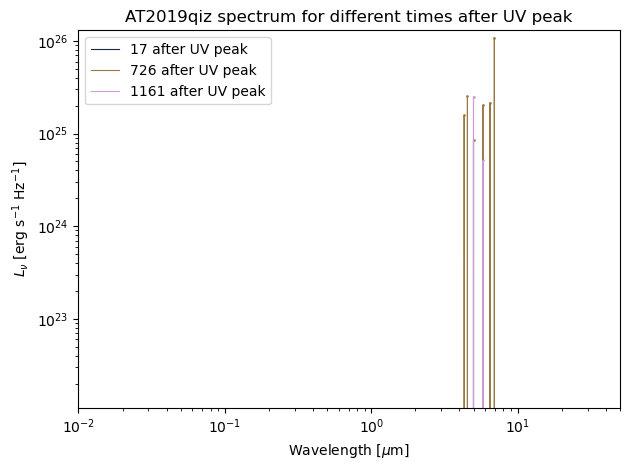

In [19]:
times=(np.array([1,50,80]))

fig=plt.figure()
ax=plt.subplot(111)

for t in range(len(times)):
    color = thesis_cmap(times[t]/len(output_t)) #Get the color from the colormap
    ax.scatter(output_wavelengths, luminosity[times[t]],color=color,s=.8)
    ax.loglog(output_wavelengths, luminosity[times[t]],label=f'{int(output_t[times[t]])} after UV peak' if len(times)>1 else '',color=color,linewidth=0.8)

ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'$L_{\nu}$ [erg s$^{-1}$ Hz$^{-1}$]')
ax.set_ylim(bottom=np.max([luminosity[t].value for t in times])/1e4,top=np.max([luminosity[t].value for t in times])*1.2)

if len(times)>1:
    ax.set_title(f'{target} spectrum for different times after UV peak')
    ax.legend()
else:
    ax.set_title(f'{target} spectrum {times} days after UV peak')

ax.set_xlim(np.min(output_wavelengths),np.max(output_wavelengths))
fig.tight_layout()
fig.savefig(PLOTFILES_+'/spectra.pdf')
plt.show()

### Making color-time diagrams

In [ ]:
fig=plt.figure()
ax=plt.subplot(111)

ax.errorbar(W1_filtered[0], WISEcolor, yerr=WISEcolor_err, fmt='o', linewidth=2, capsize=6,label=f'Color data' , color=diff_col)
ax.plot(output_t,VegaColor(lightcurve_transmission('WISE_W1', output_wavelengths, luminosity),lightcurve_transmission('WISE_W2', output_wavelengths, luminosity),distance=distance),color=diff_col, label='Simulation')
ax.scatter(output_t,VegaColor(lightcurve_transmission('WISE_W1', output_wavelengths, luminosity),lightcurve_transmission('WISE_W2', output_wavelengths, luminosity),distance=distance),color=diff_col,s=.8)

ax.set_xlim(0,np.max(output_t))
ax.set_ylim(np.min(WISEcolor)*0.7,np.max(WISEcolor)*1.3)

ax.set_xlabel(r'Time since UV peak [days]')
ax.set_ylabel(r'WISE W1-W2 color')
ax.set_title(target+' color-time diagram')
#plt.legend()
plt.tight_layout()
plt.savefig(PLOTFILES_+'color.pdf')
plt.show()

### Performing a temperature analysis

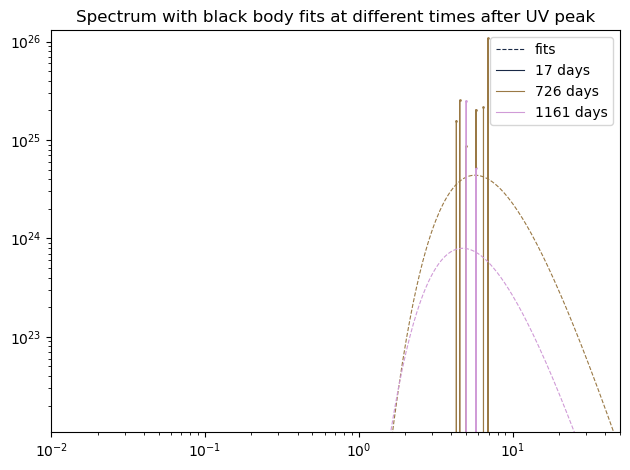

In [22]:
times=(np.array([1,50,80]))

p0 = (900,1e29)
bounds = ((200,1e25),(2e3,1e36))

fig=plt.figure()
ax=plt.subplot(111)

for t in range(len(times)):
    color = thesis_cmap(times[t]/len(output_t)) # Get the color from the colormap
    popt,pcov = curve_fit(bb_fit, wavelength, luminosity[times[t]],p0=p0) # Finding best fit
    ax.loglog(output_wavelengths, bb_fit(wavelength,popt[0],popt[1]),label='fits' if t==0 else '',color=color,linewidth=0.8,ls='--')
    
    ax.scatter(output_wavelengths, luminosity[times[t]],color=color,s=.8)
    ax.loglog(output_wavelengths, luminosity[times[t]],label=f'{int(output_t[times[t]])} days',color=color,linewidth=0.8)

ax.set_ylim(bottom=np.max([luminosity[t].value for t in times])/1e4,top=np.max([luminosity[t].value for t in times])*1.2)
ax.set_xlim(np.min(output_wavelengths),np.max(output_wavelengths))

ax.set_title("Spectrum with black body fits at different times after UV peak")
plt.legend()
fig.tight_layout()
fig.savefig(PLOTFILES_+'/spectra.pdf')
plt.show()

#### Plotting the temperature and color

14/06/2024 18:00:22.993 ! /usr/lib64/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in exp
14/06/2024 18:00:22.993 !   result = super().__array_ufunc__(function, method, *arrays, **kwargs)
14/06/2024 18:00:25.244 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:306: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:00:25.244 !   m1 = -2.5*np.log(flux1.value/fzero_w1)
14/06/2024 18:00:25.245 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:307: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:00:25.245 !   m2 = -2.5*np.log(flux2.value/fzero_w2)
14/06/2024 18:00:25.245 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:309: RuntimeWarning: invalid value encountered in subtract
14/06/2024 18:00:25.245 !   return m1-m2


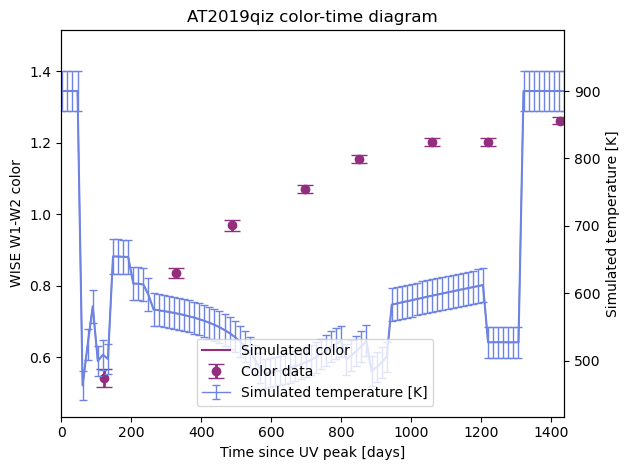

In [27]:
p0 = (900,1e29)
bounds = ((200,1e25),(2e3,1e36))

temperatures = []
temperatures_err = []

for t in range(len(output_t)):
    popt,pcov = curve_fit(bb_fit, wavelength, luminosity[t],p0=p0) # Finding best fit
    temperatures.append(popt[0])    
    temperatures_err.append(np.sqrt(np.diag(popt))[0,0])
fig=plt.figure()
ax=plt.subplot(111)

ax.errorbar(W1_filtered[0], WISEcolor, yerr=WISEcolor_err, fmt='o', linewidth=2, capsize=6,label=f'Color data' , color=diff_col)
ax.plot(output_t,VegaColor(lightcurve_transmission('WISE_W1', wavelength, luminosity),lightcurve_transmission('WISE_W2', output_wavelengths, luminosity),distance=distance),color=diff_col, label='Simulated color')
ax.scatter(output_t,VegaColor(lightcurve_transmission('WISE_W1', wavelength, luminosity),lightcurve_transmission('WISE_W2', output_wavelengths, luminosity),distance=distance),color=diff_col,s=.8)

ax2=ax.twinx()
ax2.errorbar(output_t,temperatures,yerr=temperatures_err,c='#6f83e3',linewidth=1, capsize=3,label='Simulated temperature [K]')
ax2.plot(output_t,temperatures,c='#6f83e3')

ax.set_xlim(0,np.max(output_t))
ax.set_ylim(np.min(WISEcolor)*0.8,np.max(WISEcolor)*1.2)
ax2.set_ylim(np.min(temperatures)*.9,np.max(temperatures)*1.1)

ax.set_xlabel(r'Time since UV peak [days]')
ax.set_ylabel(r'WISE W1-W2 color')
ax2.set_ylabel('Simulated temperature [K]')
ax.set_title(target+' color-time diagram')
#fig.legend(bbox_to_anchor=(.63,.25))
fig.legend(loc='lower center',bbox_to_anchor=(.5,.13))
fig.tight_layout()
plt.savefig(PLOTFILES_+'color_temp.pdf')
plt.show()

## Changing parameters
Remember to change the variable inside the get_lightcurve function when varying another variable than the optical depth example here. The same goes for the saving of the log files.

In [30]:
# Choosing the variable
var_name = 'tau'
var_values = [0.5,1]
var_unit = None

# Saving to a specific folder within the results
OUTFILES_ = OUTFILES+'change_'+var_name.replace(' ','_')+'/'
PLOTFILES_ = PLOTFILES+'change_'+var_name.replace(' ','_')+'/'

# Making some lists we will add to after the runs
OUTFILES_list = []
PLOTFILES_list = []
lightcurves, wavelengths, temperatures, radii, simulations = [],[],[],[],[]

for i in range(len(var_values)):
    OUTFILES_list.append(OUTFILES_+var_name+'='+str(var_values[i])+'/')
    PLOTFILES_list.append(PLOTFILES_+var_name+'='+str(var_values[i])+'/')

    if os.path.isdir(OUTFILES_list[i]) == False:
        os.makedirs(OUTFILES_list[i][:-1])
    if os.path.isdir(PLOTFILES_list[i]) == False:
        os.makedirs(PLOTFILES_list[i][:-1])
    
    # Starting the simulation
    
    lightcurve,wavelength,temperature,radius,simulation = get_lightcurve(np.array((Lbol_data[0],Lbol_data[1] \
                                                                             ,Lbol_data[2])) \
                                                                   ,T_data, tbol_data, output_t, np.append(output_wavelengths,relBinwidth) \
                                                                   ,[inner,outer,alpha] \
                                                                   ,[[amin_C,amax_C,grainpowerlaw_C],[amin_Si,amax_Si,grainpowerlaw_Si]], spaceBins \
                                                                   ,normalization_type=normalization_type \
                                                                   ,total_mass = total_mass, opt_depth = [var_values[i],wl_opt_depth,axis], nsizes=nsizes \
                                                                   ,static=static,FWHM=FWHM, nphotons=nphotons \
                                                                   ,distance=distance,skiname=skiname, Si=Si \
                                                                   ,prefix=str(today), OUTFILES=OUTFILES_list[i], SKIRTpath='SKIRT/release/SKIRT/main/skirt',suffix=suffix)
    lightcurves.append(lightcurve), wavelengths.append(wavelength), temperatures.append(temperature), radii.append(radius), simulations.append(simulation)
    print(f"Run {i+1} of {len(var_values)} finished")

Now simulating the lightcurve for a sphere with 15 dust grain sizes, optical depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

14/06/2024 18:03:32.302   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:03:32.302   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:03:32.304   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=0.5/2/run.ski'...
14/06/2024 18:03:39.380 - Finished setup in 6.9 s.
14/06/2024 18:03:39.647 - Finished setup output in 0.3 s.
14/06/2024 18:03:39.657 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:03:39.657 - Finished primary emission iteration 1 in 0.0 s.
14/06/2024 18:03:39.672 - Finished primary emission in 0.0 s.
14/06/2024 18:03:39.702 - Finished secondary emission iteration 1 in 0.0 s.
14/06/2024 18:03:39.730 - Finished secondary emission iteration 2 in 0.0 s.
14/06/2024 18:03:39.816 - Finished secondary emission in 0.1 s.
14/06/2024 18:03:39.816 - Finished the run in 0.2 s.


SKIRT Runs:  10%|███▏                            | 1/10 [00:09<01:21,  9.03s/it]

14/06/2024 18:03:41.225 - Finished final output in 1.4 s.
14/06/2024 18:03:41.225 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:03:41.225 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:03:41.225 - Finished simulation run using 6 threads and a single process in 8.7 s.
14/06/2024 18:03:41.236   Available memory: 15.4 GB -- Peak memory usage: 269 MB (1.7%)
14/06/2024 18:03:41.351   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:03:41.351   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:03:41.352   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=0.5/2/run.ski'...
14/06/2024 18:03:48.066 - Finished setup in 6.6 s.
14/06/2024 18:03:48.338 - Finished setup output in 0.3 s.
14/06/2024 18:03:48.369 * *** Error: Cannot destroy dust for fragmented dust mix with

SKIRT Runs:  20%|██████▍                         | 2/10 [00:17<01:10,  8.80s/it]

14/06/2024 18:03:49.866 - Finished final output in 1.3 s.
14/06/2024 18:03:49.866 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:03:49.866 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:03:49.866 - Finished simulation run using 6 threads and a single process in 8.4 s.
14/06/2024 18:03:49.876   Available memory: 15.4 GB -- Peak memory usage: 275 MB (1.7%)
14/06/2024 18:03:49.960   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:03:49.960   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:03:49.961   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=0.5/12/run.ski'...
14/06/2024 18:03:56.565 - Finished setup in 6.5 s.
14/06/2024 18:03:56.812 - Finished setup output in 0.2 s.
14/06/2024 18:03:56.820 * *** Error: Cannot destroy dust for fragmented dust mix wit

SKIRT Runs:  30%|█████████▌                      | 3/10 [00:26<01:00,  8.61s/it]

14/06/2024 18:03:58.253 - Finished final output in 1.3 s.
14/06/2024 18:03:58.253 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:03:58.253 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:03:58.254 - Finished simulation run using 6 threads and a single process in 8.2 s.
14/06/2024 18:03:58.263   Available memory: 15.4 GB -- Peak memory usage: 279 MB (1.8%)
14/06/2024 18:03:58.346   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:03:58.346   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:03:58.347   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=0.5/33/run.ski'...
14/06/2024 18:04:05.317 - Finished setup in 6.9 s.
14/06/2024 18:04:05.708 - Finished setup output in 0.4 s.
14/06/2024 18:04:05.732 * *** Error: Cannot destroy dust for fragmented dust mix wit

SKIRT Runs:  40%|████████████▊                   | 4/10 [00:35<00:52,  8.75s/it]

14/06/2024 18:04:07.201 - Finished final output in 1.4 s.
14/06/2024 18:04:07.201 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:04:07.201 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:04:07.201 - Finished simulation run using 6 threads and a single process in 8.8 s.
14/06/2024 18:04:07.212   Available memory: 15.4 GB -- Peak memory usage: 284 MB (1.8%)
14/06/2024 18:04:07.300   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:04:07.300   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:04:07.301   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=0.5/101/run.ski'...
14/06/2024 18:04:14.108 - Finished setup in 6.7 s.
14/06/2024 18:04:14.359 - Finished setup output in 0.2 s.
14/06/2024 18:04:14.386 * *** Error: Cannot destroy dust for fragmented dust mix wi

SKIRT Runs:  50%|████████████████                | 5/10 [00:43<00:43,  8.72s/it]

14/06/2024 18:04:15.857 - Finished final output in 1.3 s.
14/06/2024 18:04:15.857 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:04:15.857 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:04:15.857 - Finished simulation run using 6 threads and a single process in 8.5 s.
14/06/2024 18:04:15.869   Available memory: 15.4 GB -- Peak memory usage: 288 MB (1.8%)
14/06/2024 18:04:15.962   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:04:15.962   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:04:15.963   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=0.5/374/run.ski'...
14/06/2024 18:04:22.581 - Finished setup in 6.5 s.
14/06/2024 18:04:22.923 - Finished setup output in 0.3 s.
14/06/2024 18:04:22.940 * *** Error: Cannot destroy dust for fragmented dust mix wi

SKIRT Runs:  60%|███████████████████▏            | 6/10 [00:52<00:34,  8.66s/it]

14/06/2024 18:04:24.418 - Finished final output in 1.3 s.
14/06/2024 18:04:24.418 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:04:24.418 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:04:24.418 - Finished simulation run using 6 threads and a single process in 8.4 s.
14/06/2024 18:04:24.430   Available memory: 15.4 GB -- Peak memory usage: 292 MB (1.8%)
14/06/2024 18:04:24.544   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:04:24.544   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:04:24.545   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=0.5/448/run.ski'...
14/06/2024 18:04:31.851 - Finished setup in 7.2 s.
14/06/2024 18:04:32.094 - Finished setup output in 0.2 s.
14/06/2024 18:04:32.100 * *** Error: Cannot destroy dust for fragmented dust mix wi

SKIRT Runs:  70%|██████████████████████▍         | 7/10 [01:01<00:26,  8.83s/it]

14/06/2024 18:04:33.601 - Finished final output in 1.4 s.
14/06/2024 18:04:33.601 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:04:33.601 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:04:33.601 - Finished simulation run using 6 threads and a single process in 9.0 s.
14/06/2024 18:04:33.611   Available memory: 15.4 GB -- Peak memory usage: 296 MB (1.9%)
14/06/2024 18:04:33.718   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:04:33.718   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:04:33.719   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=0.5/718/run.ski'...
14/06/2024 18:04:40.626 - Finished setup in 6.7 s.
14/06/2024 18:04:40.978 - Finished setup output in 0.4 s.
14/06/2024 18:04:40.996 * *** Error: Cannot destroy dust for fragmented dust mix wi

SKIRT Runs:  80%|█████████████████████████▌      | 8/10 [01:10<00:17,  8.85s/it]

14/06/2024 18:04:42.500 - Finished final output in 1.4 s.
14/06/2024 18:04:42.500 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:04:42.500 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:04:42.500 - Finished simulation run using 6 threads and a single process in 8.6 s.
14/06/2024 18:04:42.512   Available memory: 15.4 GB -- Peak memory usage: 301 MB (1.9%)
14/06/2024 18:04:42.616   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:04:42.616   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:04:42.618   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=0.5/825/run.ski'...
14/06/2024 18:04:49.456 - Finished setup in 6.7 s.
14/06/2024 18:04:49.697 - Finished setup output in 0.2 s.
14/06/2024 18:04:49.703 * *** Error: Cannot destroy dust for fragmented dust mix wi

SKIRT Runs:  90%|████████████████████████████▊   | 9/10 [01:19<00:08,  8.87s/it]

14/06/2024 18:04:51.416 - Finished final output in 1.6 s.
14/06/2024 18:04:51.416 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:04:51.416 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:04:51.416 - Finished simulation run using 6 threads and a single process in 8.7 s.
14/06/2024 18:04:51.426   Available memory: 15.4 GB -- Peak memory usage: 305 MB (1.9%)
14/06/2024 18:04:51.509   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:04:51.509   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:04:51.510   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=0.5/1089/run.ski'...
14/06/2024 18:04:58.250 - Finished setup in 6.7 s.
14/06/2024 18:04:58.500 - Finished setup output in 0.2 s.
14/06/2024 18:04:58.534 * *** Error: Cannot destroy dust for fragmented dust mix w

SKIRT Runs: 100%|███████████████████████████████| 10/10 [01:27<00:00,  8.78s/it]


14/06/2024 18:04:59.941 - Finished final output in 1.3 s.
14/06/2024 18:04:59.941 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:04:59.941 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:04:59.941 - Finished simulation run using 6 threads and a single process in 8.3 s.
14/06/2024 18:04:59.952   Available memory: 15.4 GB -- Peak memory usage: 309 MB (2.0%)


100%|█████████████████████████████████████████| 185/185 [00:03<00:00, 59.96it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:00<00:02, 40.24it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:00<00:04, 18.80it/s]

Compile Lightcurve:  14%|███                   | 14/100 [00:00<00:06, 13.88it/s]

Compile Lightcurve:  16%|███▌                  | 16/100 [00:01<00:07, 11.43it/s]

Compile Lightcurve:  18%|███▉                  | 18/100 [00:01<00:08,  9.59it/s]

Compile Lightcurve:  20%|████▍                 | 20/100 [00:01<00:09,  8.18it/s]

Compile Lightcurve:  21%|████▌                 | 21/100 [00:01<00:10,  7.52it/s]

Compile Lightcurve:  22%|████▊                 | 22/100 [00:02<00:11,  6.91it/s]

Compile Lightcurve:  23%|█████                 | 23/100 [00:02<00:12,  6.32it/s]

Compile Lightcurve:  24%|█████▎                | 24/100 [00:02<00:13,  5.82it/s]

Compile Lightcu

Run 1 of 2 finished
Now simulating the lightcurve for a sphere with 15 dust grain sizes, optical depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

14/06/2024 18:05:49.955   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:05:49.955   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:05:49.956   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=1/2/run.ski'...
14/06/2024 18:05:56.721 - Finished setup in 6.6 s.
14/06/2024 18:05:56.967 - Finished setup output in 0.2 s.
14/06/2024 18:05:56.975 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:05:56.977 - Finished primary emission iteration 1 in 0.0 s.
14/06/2024 18:05:56.990 - Finished primary emission in 0.0 s.
14/06/2024 18:05:57.018 - Finished secondary emission iteration 1 in 0.0 s.
14/06/2024 18:05:57.040 - Finished secondary emission iteration 2 in 0.0 s.
14/06/2024 18:05:57.060 - Finished secondary emission iteration 3 in 0.0 s.
14/06/2024 18:05:57.131 - Finished secondary emission in 0.1 s.
14/0

SKIRT Runs:  10%|███▏                            | 1/10 [00:08<01:17,  8.61s/it]

14/06/2024 18:05:58.434 - Finished final output in 1.3 s.
14/06/2024 18:05:58.434 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:05:58.434 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:05:58.434 - Finished simulation run using 6 threads and a single process in 8.3 s.
14/06/2024 18:05:58.444   Available memory: 15.4 GB -- Peak memory usage: 313 MB (2.0%)
14/06/2024 18:05:58.559   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:05:58.559   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:05:58.560   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=1/2/run.ski'...
14/06/2024 18:06:05.391 - Finished setup in 6.7 s.
14/06/2024 18:06:05.657 - Finished setup output in 0.3 s.
14/06/2024 18:06:05.667 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  20%|██████▍                         | 2/10 [00:17<01:09,  8.70s/it]

14/06/2024 18:06:07.198 - Finished final output in 1.3 s.
14/06/2024 18:06:07.198 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:06:07.198 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:06:07.198 - Finished simulation run using 6 threads and a single process in 8.5 s.
14/06/2024 18:06:07.210   Available memory: 15.4 GB -- Peak memory usage: 313 MB (2.0%)
14/06/2024 18:06:07.298   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:06:07.298   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:06:07.299   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=1/12/run.ski'...
14/06/2024 18:06:13.954 - Finished setup in 6.6 s.
14/06/2024 18:06:14.206 - Finished setup output in 0.3 s.
14/06/2024 18:06:14.225 * *** Error: Cannot destroy dust for fragmented dust mix witho

SKIRT Runs:  30%|█████████▌                      | 3/10 [00:25<01:00,  8.62s/it]

14/06/2024 18:06:15.728 - Finished final output in 1.3 s.
14/06/2024 18:06:15.728 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:06:15.728 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:06:15.728 - Finished simulation run using 6 threads and a single process in 8.3 s.
14/06/2024 18:06:15.740   Available memory: 15.4 GB -- Peak memory usage: 313 MB (2.0%)
14/06/2024 18:06:15.827   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:06:15.827   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:06:15.829   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=1/33/run.ski'...
14/06/2024 18:06:22.583 - Finished setup in 6.7 s.
14/06/2024 18:06:22.831 - Finished setup output in 0.2 s.
14/06/2024 18:06:22.839 * *** Error: Cannot destroy dust for fragmented dust mix witho

SKIRT Runs:  40%|████████████▊                   | 4/10 [00:34<00:51,  8.65s/it]

14/06/2024 18:06:24.425 - Finished final output in 1.3 s.
14/06/2024 18:06:24.425 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:06:24.425 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:06:24.425 - Finished simulation run using 6 threads and a single process in 8.5 s.
14/06/2024 18:06:24.439   Available memory: 15.4 GB -- Peak memory usage: 313 MB (2.0%)
14/06/2024 18:06:24.529   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:06:24.529   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:06:24.531   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=1/101/run.ski'...
14/06/2024 18:06:31.555 - Finished setup in 6.9 s.
14/06/2024 18:06:31.804 - Finished setup output in 0.2 s.
14/06/2024 18:06:31.814 * *** Error: Cannot destroy dust for fragmented dust mix with

SKIRT Runs:  50%|████████████████                | 5/10 [00:43<00:43,  8.79s/it]

14/06/2024 18:06:33.476 - Finished final output in 1.5 s.
14/06/2024 18:06:33.476 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:06:33.476 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:06:33.476 - Finished simulation run using 6 threads and a single process in 8.9 s.
14/06/2024 18:06:33.486   Available memory: 15.4 GB -- Peak memory usage: 313 MB (2.0%)
14/06/2024 18:06:33.569   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:06:33.569   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:06:33.570   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=1/374/run.ski'...
14/06/2024 18:06:40.347 - Finished setup in 6.7 s.
14/06/2024 18:06:40.622 - Finished setup output in 0.3 s.
14/06/2024 18:06:40.644 * *** Error: Cannot destroy dust for fragmented dust mix with

SKIRT Runs:  60%|███████████████████▏            | 6/10 [00:52<00:34,  8.73s/it]

14/06/2024 18:06:42.066 - Finished final output in 1.3 s.
14/06/2024 18:06:42.066 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:06:42.066 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:06:42.066 - Finished simulation run using 6 threads and a single process in 8.4 s.
14/06/2024 18:06:42.078   Available memory: 15.4 GB -- Peak memory usage: 313 MB (2.0%)
14/06/2024 18:06:42.165   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:06:42.165   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:06:42.166   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=1/448/run.ski'...
14/06/2024 18:06:48.862 - Finished setup in 6.6 s.
14/06/2024 18:06:49.201 - Finished setup output in 0.3 s.
14/06/2024 18:06:49.215 * *** Error: Cannot destroy dust for fragmented dust mix with

SKIRT Runs:  70%|██████████████████████▍         | 7/10 [01:00<00:26,  8.72s/it]

14/06/2024 18:06:50.765 - Finished final output in 1.4 s.
14/06/2024 18:06:50.765 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:06:50.765 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:06:50.765 - Finished simulation run using 6 threads and a single process in 8.5 s.
14/06/2024 18:06:50.779   Available memory: 15.4 GB -- Peak memory usage: 313 MB (2.0%)
14/06/2024 18:06:50.906   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:06:50.906   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:06:50.907   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=1/718/run.ski'...
14/06/2024 18:06:57.633 - Finished setup in 6.5 s.
14/06/2024 18:06:57.900 - Finished setup output in 0.3 s.
14/06/2024 18:06:57.928 * *** Error: Cannot destroy dust for fragmented dust mix with

SKIRT Runs:  80%|█████████████████████████▌      | 8/10 [01:09<00:17,  8.69s/it]

14/06/2024 18:06:59.393 - Finished final output in 1.4 s.
14/06/2024 18:06:59.393 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:06:59.393 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:06:59.393 - Finished simulation run using 6 threads and a single process in 8.3 s.
14/06/2024 18:06:59.403   Available memory: 15.4 GB -- Peak memory usage: 313 MB (2.0%)
14/06/2024 18:06:59.505   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:06:59.505   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:06:59.506   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=1/825/run.ski'...
14/06/2024 18:07:06.173 - Finished setup in 6.6 s.
14/06/2024 18:07:06.417 - Finished setup output in 0.2 s.
14/06/2024 18:07:06.452 * *** Error: Cannot destroy dust for fragmented dust mix with

SKIRT Runs:  90%|████████████████████████████▊   | 9/10 [01:18<00:08,  8.66s/it]

14/06/2024 18:07:08.006 - Finished final output in 1.4 s.
14/06/2024 18:07:08.006 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:07:08.006 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:07:08.007 - Finished simulation run using 6 threads and a single process in 8.4 s.
14/06/2024 18:07:08.019   Available memory: 15.4 GB -- Peak memory usage: 313 MB (2.0%)
14/06/2024 18:07:08.132   Welcome to SKIRT v9.0 (git ab870716 built on 14/06/2024 at 17:27:33)
14/06/2024 18:07:08.132   Running on student72.strw.leidenuniv.nl for lankhorst
14/06/2024 18:07:08.134   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/test/test2/results/AT2019qiz/2024-06-14/1734/change_tau/tau=1/1089/run.ski'...
14/06/2024 18:07:14.934 - Finished setup in 6.7 s.
14/06/2024 18:07:15.262 - Finished setup output in 0.3 s.
14/06/2024 18:07:15.273 * *** Error: Cannot destroy dust for fragmented dust mix wit

SKIRT Runs: 100%|███████████████████████████████| 10/10 [01:26<00:00,  8.69s/it]


14/06/2024 18:07:16.749 - Finished final output in 1.3 s.
14/06/2024 18:07:16.749 * *** Error: The following error message was issued during this simulation:
14/06/2024 18:07:16.749 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
14/06/2024 18:07:16.749 - Finished simulation run using 6 threads and a single process in 8.5 s.
14/06/2024 18:07:16.761   Available memory: 15.4 GB -- Peak memory usage: 313 MB (2.0%)


100%|█████████████████████████████████████████| 185/185 [00:03<00:00, 60.53it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:00<00:02, 40.65it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:00<00:04, 18.51it/s]

Compile Lightcurve:  14%|███                   | 14/100 [00:00<00:06, 13.56it/s]

Compile Lightcurve:  16%|███▌                  | 16/100 [00:01<00:07, 11.27it/s]

Compile Lightcurve:  18%|███▉                  | 18/100 [00:01<00:08,  9.56it/s]

Compile Lightcurve:  20%|████▍                 | 20/100 [00:01<00:09,  8.11it/s]

Compile Lightcurve:  21%|████▌                 | 21/100 [00:02<00:10,  7.44it/s]

Compile Lightcurve:  22%|████▊                 | 22/100 [00:02<00:11,  6.77it/s]

Compile Lightcurve:  23%|█████                 | 23/100 [00:02<00:12,  6.18it/s]

Compile Lightcurve:  24%|█████▎                | 24/100 [00:02<00:13,  5.71it/s]

Compile Lightcu

Run 2 of 2 finished


### Saving the data

In [31]:
w1_idxs = []
w2_idxs = []
luminosities = []

for i in range(len(lightcurves)):
    # Indices corresponding to the WISE filter wavelengths
    w1_idxs.append(np.argmin(np.abs(wavelengths[i]-wl_w1.value)))
    w2_idxs.append(np.argmin(np.abs(wavelengths[i]-wl_w2.value)))
    
    # Convert the lightcurve to luminosity
    luminosities.append(FluxtoLum(lightcurves[i],distance=distance))
    
    # Save the simulation's parameters
    with open(OUTFILES_list[i]+'log.txt','a') as log:
        # Normalization
        log.write('Normalization method: '+normalization_type.replace("_"," ")+'\n')
        if normalization_type == 'mass':
            log.write('Total mass='+str(total_mass)+' solar masses \n')
        else:
            log.write('Optical depth of '+str(var_values[i])+' at '+str(wl_opt_depth)+' micron over the '+axis+' axis. \n')
    
        # Dust grains
        log.write('Silicates fraction='+str(Si)+', number of dust grain sizes='+str(nsizes)+'\n')
        if Si!=0:
            log.write('amin_Si='+str(amin_Si)+', amax_Si='+str(amax_Si)+', Si grainpowerlaw ='+str(grainpowerlaw_Si)+'\n' )
        if Si!=1:
            log.write('amin_C='+str(amin_C)+', amax_C='+str(amax_C)+', C grainpowerlaw ='+str(grainpowerlaw_C)+'\n' )
    
        # Geometry
        log.write('Inner radius='+str(inner)+' pc, outer radius='+str(outer)+' pc, radial density powerlaw='+str(alpha)+ ' \n')
    
        # Simulation properties
        log.write('Number of photons='+str(nphotons)+', spatial bins:'+str(spaceBins)+'static='+str(static)+' \n')
    
        # Some simulation outcomes
        log.write('Sublimation radius='+str(np.min(radii[i]))+', T_min='+np.array2string(np.array(temperatures[i]),max_line_width=len(temperatures[i])*100))
        log.write('\n')
    
    if os.path.isdir(PLOTFILES_list[i]+'/')==False:
        os.makedirs(PLOTFILES_list[i]+'/')
    
    #Saving data that can be used to (re)create any plots
    np.savetxt(OUTFILES_list[i]+'luminosity_data.txt',luminosities[i].value)
    np.savetxt(OUTFILES_list[i]+'wavelengths.txt',wavelengths[i])
    np.savetxt(OUTFILES_list[i]+'output_times.txt',output_t)

### Finding the covering factors

In [33]:
coveringFactors = []
for i in range(len(luminosities)):
    coveringFactors.append(np.max(W1_filtered[1]*u.erg/u.s/u.Hz)/lightcurve_transmission('WISE_W1', output_wavelengths, luminosities[i])[np.argmin(np.abs(output_t-W1_filtered[0,np.argmax(W1_filtered[1])]))])

    # Saving them to the log as well
    with open(OUTFILES_list[i]+'log.txt','a') as log:
        log.write('Covering factor='+str(coveringFactors[i])+'\n')

    print(f"The covering factor for {str(var_name)}={str(var_values[i])} is {str(coveringFactors[i])} .")

The covering factor for tau=0.5 is inf .
The covering factor for tau=1 is inf .


### Making the light curves

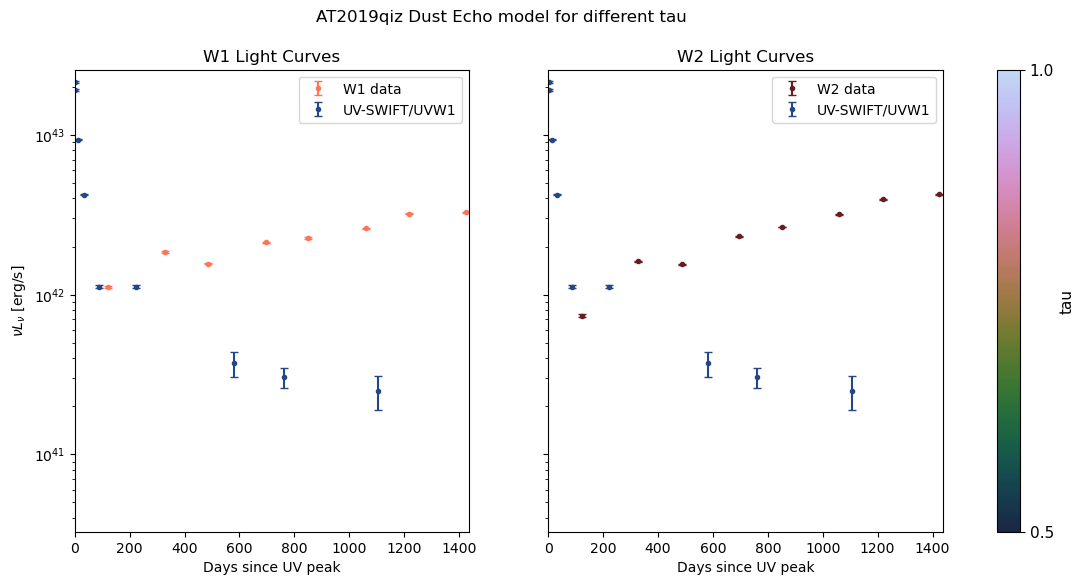

In [34]:
# Decide if you want to plot with covering factor and/or the data
cover = False
data = True

# Defining the nu_Lnu from the simulations, using the transmission curve
nu_Lnu_w1s = np.array([((c.c/wl_w1)*lightcurve_transmission('WISE_W1', output_wavelengths, lum)).to(u.erg/u.s) for lum in luminosities])
nu_Lnu_w2s = np.array([((c.c/wl_w2)*lightcurve_transmission('WISE_W2', output_wavelengths, lum)).to(u.erg/u.s) for lum in luminosities])

#nu_Lnu_w1s.append(((c.c/wl_w1)*lightcurve_transmission('WISE_W1', output_wavelengths, luminosities[i])).to(u.erg/u.s))
#nu_Lnu_w2s.append(((c.c/wl_w2)*lightcurve_transmission('WISE_W2', output_wavelengths, luminosities[i])).to(u.erg/u.s))

# Normalize the variable's values for the color mapping. 
# Can choose log or linear depending on the situation.

#norm = colors.LogNorm(vmin=min(var_values), vmax=max(var_values))
norm = colors.Normalize(vmin=min(var_values), vmax=max(var_values))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

for i in range(len(var_values)):
    color = thesis_cmap(norm(var_values[i]))
    if cover:
        ax1.plot(output_t, coveringFactors[i]*nu_Lnu_w1s[i], color = color)
        ax2.plot(output_t, coveringFactors[i]*nu_Lnu_w2s[i], color = color)
        fig.suptitle(target + f' Dust Echo light curve for changing {var_name} with covering factor')
        
    else:
        ax1.plot(output_t, nu_Lnu_w1s[i], color = color)
        ax2.plot(output_t, nu_Lnu_w2s[i], color = color)
        fig.suptitle(target + f' Dust Echo light curve for changing {var_name}')
        
if data:
    ax1.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color=W1_col)
    ax1.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color=UV_col,capsize=3,label='UV-SWIFT/UVW1')
    ax2.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color=W2_col)
    ax2.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color=UV_col,capsize=3,label='UV-SWIFT/UVW1')
    

ax1.set_xlim(0,np.max(output_t))
ax1.set_xlabel('Days since UV peak')

if data:
    ax1.set_ylim(bottom=(c.c/wl_w1).to(u.Hz).value*np.max(W1[1])/1e2,top=np.max((np.append((nu_Lnu_w1s)*1.2, np.max(L_data[1])*1.2))))
else:
    ax1.set_ylim(bottom=np.max(nu_Lnu_w2.value)/1e2, top=np.max(nu_Lnu_w1.value)*1.2)

ax1.set_yscale('log')
ax1.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax1.set_title('W1 Light Curves')
ax1.legend()

ax2.set_xlabel('Days since UV peak')
ax2.set_xlim(0,np.max(output_t))
ax2.set_title('W2 Light Curves')
ax2.legend()

# Making the colorbar
sm = ScalarMappable(cmap=thesis_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='vertical')
tick_values = var_values
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)

if var_unit != None:
    cbar.set_label(str(var_name)+f' [{var_unit}]', fontsize=11)
else:
    cbar.set_label(str(var_name), fontsize=11)

fig.suptitle(target + f' Dust Echo model for different {var_name}', x=.43)

if cover and data:
    fig.savefig(PLOTFILES_ + '/Lightcurve_cov_data.pdf')
elif cover and not data:
    fig.savefig(PLOTFILES_ + '/Lightcurve_cov.pdf')    
elif data and not cover:
    fig.savefig(PLOTFILES_ + '/Lightcurve_data.pdf')
else:
    fig.savefig(PLOTFILES_ + '/Lightcurve.pdf')
plt.show()

### Making spectra

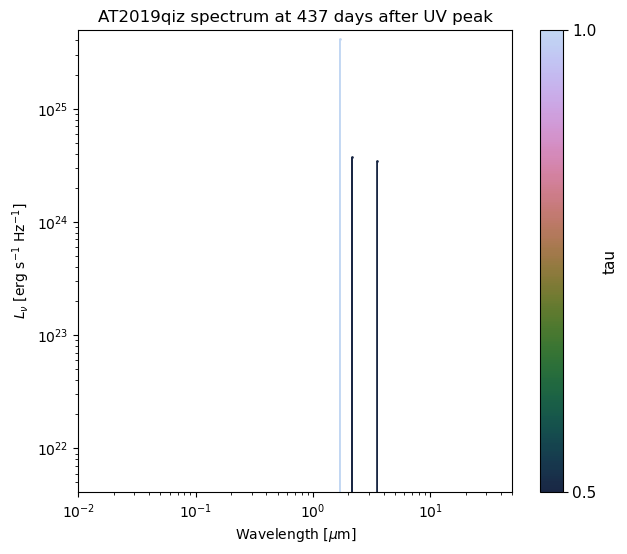

In [35]:
time_idx = 30 # Index of the time at which you want to show the spectra
fig,ax = plt.subplots(1,1,figsize=(7,6))

# Normalize the variable's values for the color mapping. 
# Can choose log or linear depending on the situation.
#norm = colors.LogNorm(vmin=min(var_values), vmax=max(var_values))
norm = colors.Normalize(vmin=min(var_values), vmax=max(var_values))

for i in range(len(var_values)):
    color = thesis_cmap(norm(var_values[i]))
    ax.loglog(output_wavelengths, luminosities[i][time_idx], c=color, linewidth=.8)
    ax.scatter(output_wavelengths, luminosities[i][time_idx], color=color, s=.8)

# Make the colorbar
sm = ScalarMappable(cmap=thesis_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
tick_values = var_values
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)

if var_unit != None:
    cbar.set_label(str(var_name)+f' [{var_unit}]', fontsize=11)
else:
    cbar.set_label(str(var_name), fontsize=11)

ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'$L_{\nu}$ [erg s$^{-1}$ Hz$^{-1}$]')
ax.set_ylim(bottom=np.max(np.array(luminosities)[:,time_idx])/1e4,top=np.max(np.array(luminosities)[:,time_idx])*1.2)

ax.set_title(f'{target} spectrum at {int(output_t[time_idx])} days after UV peak')
ax.set_xlim(np.min(output_wavelengths),np.max(output_wavelengths))
fig.savefig(PLOTFILES_+f'/spectra_{var_name}.pdf')
plt.show()

### Making color-time diagrams

14/06/2024 18:43:42.750 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:306: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:43:42.750 !   m1 = -2.5*np.log(flux1.value/fzero_w1)
14/06/2024 18:43:42.751 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:307: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:43:42.751 !   m2 = -2.5*np.log(flux2.value/fzero_w2)
14/06/2024 18:43:42.751 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:309: RuntimeWarning: invalid value encountered in subtract
14/06/2024 18:43:42.751 !   return m1-m2


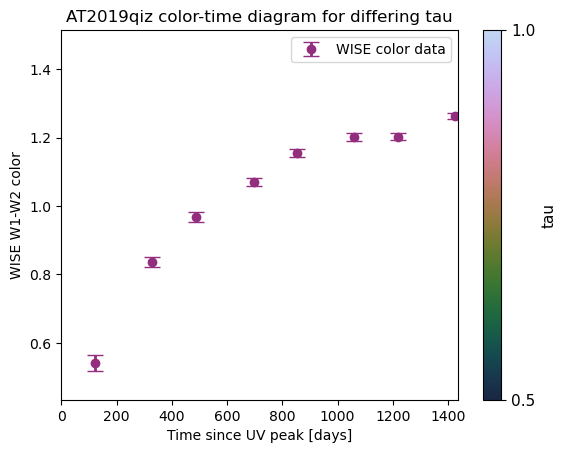

In [36]:
# Normalize the variable's values for the color mapping. 
# Can choose log or linear depending on the situation.
#norm = colors.LogNorm(vmin=min(var_values), vmax=max(var_values))
norm = colors.Normalize(vmin=min(var_values), vmax=max(var_values))

fig=plt.figure()
ax=plt.subplot(111)

ax.errorbar(W1_filtered[0], WISEcolor, yerr=WISEcolor_err, fmt='o', linewidth=2, capsize=6,label=f'WISE color data' , color=diff_col)

for i in range(len(var_values)):
    color = thesis_cmap(norm(var_values[i]))
    ax.plot(output_t,VegaColor(lightcurve_transmission('WISE_W1', output_wavelengths, luminosities[i]),lightcurve_transmission('WISE_W2', output_wavelengths, luminosities[i]),distance=distance),color=color)
    ax.scatter(output_t,VegaColor(lightcurve_transmission('WISE_W1', output_wavelengths, luminosities[i]),lightcurve_transmission('WISE_W2', output_wavelengths, luminosities[i]),distance=distance),color=color,s=.8)

# Make the colorbar
sm = ScalarMappable(cmap=thesis_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
tick_values = var_values
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)
if var_unit != None:
    cbar.set_label(str(var_name)+f' [{var_unit}]', fontsize=11)
else:
    cbar.set_label(str(var_name), fontsize=11)

ax.set_xlim(0,np.max(output_t))
ax.set_ylim(np.min(WISEcolor)*0.8,np.max(WISEcolor)*1.2)

ax.set_xlabel(r'Time since UV peak [days]')
ax.set_ylabel(r'WISE W1-W2 color')
ax.set_title(target+f' color-time diagram for differing {var_name}')
plt.legend()
plt.savefig(PLOTFILES_+'color.pdf')
plt.show()

### Performing a temperature analysis

14/06/2024 18:43:45.399 ! /usr/lib64/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in exp
14/06/2024 18:43:45.399 !   result = super().__array_ufunc__(function, method, *arrays, **kwargs)


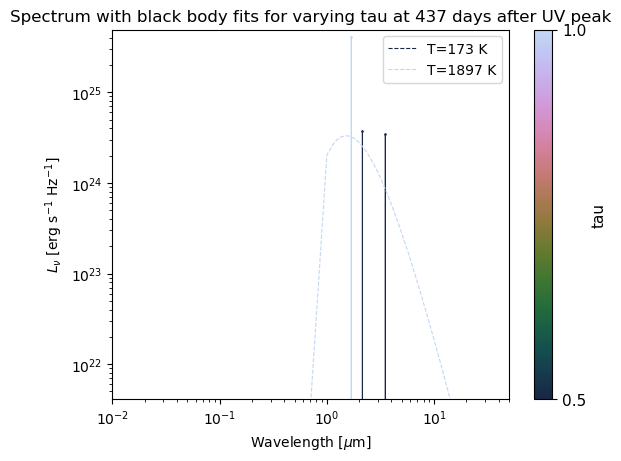

In [37]:
time_idx = 30 # Index of the time at which you want to show the spectra

# Normalize the variable's values for the color mapping. 
# Can choose log or linear depending on the situation.
#norm = colors.LogNorm(vmin=min(var_values), vmax=max(var_values))
norm = colors.Normalize(vmin=min(var_values), vmax=max(var_values))

p0 = (900,1e29)
bounds = ((200,1e25),(2e3,1e36))

fig=plt.figure()
ax=plt.subplot(111)

for i in range(len(var_values)):
    color = thesis_cmap(norm(var_values[i]))
    ax.scatter(output_wavelengths, luminosities[i][time_idx],color=color,s=.8)
    ax.loglog(output_wavelengths, luminosities[i][time_idx],color=color,linewidth=0.8)

    popt,pcov = curve_fit(bb_fit, output_wavelengths, luminosities[i][time_idx],p0=p0) # Finding best fit
    ax.loglog(output_wavelengths, bb_fit(output_wavelengths,popt[0],popt[1]), color=color,linewidth=0.8,ls='--',label=f'T={int(popt[0])} K')

# Make the colorbar
sm = ScalarMappable(cmap=thesis_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
tick_values = var_values
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)
if var_unit != None:
    cbar.set_label(str(var_name)+f' [{var_unit}]', fontsize=11)
else:
    cbar.set_label(str(var_name), fontsize=11)

ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'$L_{\nu}$ [erg s$^{-1}$ Hz$^{-1}$]')
ax.set_ylim(bottom=np.max(np.array(luminosities)[:,time_idx])/1e4,top=np.max(np.array(luminosities)[:,time_idx])*1.2)
ax.set_xlim(np.min(output_wavelengths),np.max(output_wavelengths))
ax.set_title(f"Spectrum with black body fits for varying {var_name} at {int(output_t[time_idx])} days after UV peak")
plt.legend()
fig.savefig(PLOTFILES_+'/spectra_blackbodyfits.pdf')
plt.show()

#### Plotting the temperature and color

14/06/2024 18:44:03.316 ! /usr/lib64/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in exp
14/06/2024 18:44:03.316 !   result = super().__array_ufunc__(function, method, *arrays, **kwargs)
14/06/2024 18:44:04.116 ! /usr/lib64/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in multiply
14/06/2024 18:44:04.116 !   result = super().__array_ufunc__(function, method, *arrays, **kwargs)
14/06/2024 18:44:05.658 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:306: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:44:05.658 !   m1 = -2.5*np.log(flux1.value/fzero_w1)
14/06/2024 18:44:05.658 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:307: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:44:05.658 !   m2 = -2.5*np.log(flux2.value/fzero_w2)
14/06/2024 18:44:05.659 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:309: RuntimeWarning: invalid value encoun

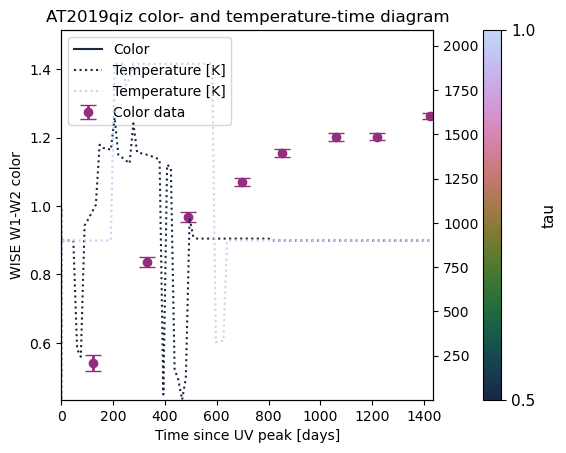

In [38]:
p0 = (900,1e29)
bounds = ((200,1e25),(2e3,1e36))

sim_temperatures = []

for i in range(len(var_values)):
    temp_temp = []
    for t in range(len(output_t)):
        popt,pcov = curve_fit(bb_fit, wavelengths[i], luminosities[i][t],p0=p0) # Finding best fit
        temp_temp.append(popt[0])
    sim_temperatures.append(temp_temp)
    
# Normalize the variable's values for the color mapping. 
# Can choose log or linear depending on the situation.
#norm = colors.LogNorm(vmin=min(var_values), vmax=max(var_values))
norm = colors.Normalize(vmin=min(var_values), vmax=max(var_values))

fig=plt.figure()
ax=plt.subplot(111)

ax.errorbar(W1_filtered[0], WISEcolor, yerr=WISEcolor_err, fmt='o', linewidth=2, capsize=6,label=f'Color data' , color=diff_col)
for i in range(len(sim_temperatures)):
    color = thesis_cmap(norm(var_values[i]))
    ax.plot(output_t,VegaColor(lightcurve_transmission('WISE_W1', output_wavelengths, luminosities[i]),lightcurve_transmission('WISE_W2', output_wavelengths, luminosities[i]),distance=distance),color=color, label='Color' if i==0 else '')
    ax.scatter(output_t,VegaColor(lightcurve_transmission('WISE_W1', output_wavelengths, luminosities[i]),lightcurve_transmission('WISE_W2', output_wavelengths, luminosities[i]),distance=distance),color=color,s=.8)
    ax.plot([0,1],[0,1],color=color, ls='dotted', label='Temperature [K]')
    
ax2=ax.twinx()
for i in range(len(sim_temperatures)):
    color = thesis_cmap(norm(var_values[i]))
    ax2.plot(output_t,sim_temperatures[i],c=color,label='Temperature [K]',ls='dotted')

# Make the colorbar
sm = ScalarMappable(cmap=thesis_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical',pad=0.1)
tick_values = var_values
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)
if var_unit != None:
    cbar.set_label(str(var_name)+f' [{var_unit}]', fontsize=11)
else:
    cbar.set_label(str(var_name), fontsize=11)

ax.set_xlim(0,np.max(output_t))
ax.set_ylim(np.min(WISEcolor)*0.8,np.max(WISEcolor)*1.2)
ax2.set_ylim(np.min(sim_temperatures)*.9,np.max(sim_temperatures)*1.1)

ax.set_xlabel(r'Time since UV peak [days]')
ax.set_ylabel(r'WISE W1-W2 color')
ax2.set_ylabel('Simulated temperature [K]')
ax.set_title(target+' color- and temperature-time diagram')
#fig.legend(bbox_to_anchor=(.63,.25))
ax.legend()
plt.savefig(PLOTFILES_+'color_temp.pdf')
plt.show()

# Analysing existing data
Here, previously obtained data can be used to make the same plots as above.

## For a single run

In [39]:
file_loc = '/home/lankhorst/Desktop/Link to Lankhorst/brp2/results/AT2019qiz/2024-06-13/1607/change_Lbol_factor/Lbol_factor=1'

luminosity=np.genfromtxt(file_loc+str('/luminosity.txt'),delimiter = ' ') * u.erg/u.Hz/u.s
wavelengths = np.genfromtxt(file_loc+str('/wavelengths.txt'),delimiter = ' ')
output_t = np.genfromtxt(file_loc+str('/output_times.txt'),delimiter = ' ')

OUTFILES_ = OUTFILES+'old_data'+'/'
PLOTFILES_ = PLOTFILES+'old_data'+'/'

if os.path.isdir(OUTFILES_) == False:
    os.makedirs(OUTFILES_[:-1])
if os.path.isdir(PLOTFILES_) == False:
    os.makedirs(PLOTFILES_[:-1])

### Finding the covering factor


In [40]:
time_cutoff = int(np.argwhere(output_t>L_data[0][-1])[0])

mask = W1_filtered[0]<output_t[time_cutoff]
W1_filtered2 = np.array([W1_filtered[i][mask] for i in range(len(W1_filtered))])

coveringFactor=np.max(W1_filtered2[1]*u.erg/u.s/u.Hz)/lightcurve_transmission('WISE_W1', wavelengths, luminosity)[np.argmin(np.abs(output_t-W1_filtered2[0,np.argmax(W1_filtered2[1])]))]

# Saving this to the log as well
with open(OUTFILES_+'log.txt','a') as log:
    log.write('Covering factor='+str(coveringFactor)+'\n')

print(f"The covering factor is {coveringFactor} .")

The covering factor is 1509.3332520862764 .


### Making the light curves

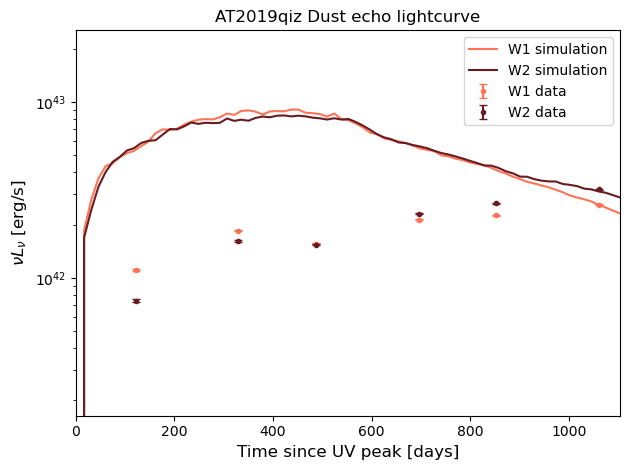

In [41]:
title = str(target+' Dust echo lightcurve')
time_cutoff = int(np.argwhere(output_t>L_data[0][-1])[0])
#Decide if you want to plot with covering factor and/or the data
cover = True
data = True

#Defining the nu_Lnu from the simulations, using the transmission curve
nu_Lnu_w1 = ((c.c/wl_w1)*lightcurve_transmission('WISE_W1', wavelengths, luminosity)).to(u.erg/u.s)
nu_Lnu_w2 = ((c.c/wl_w2)*lightcurve_transmission('WISE_W2', wavelengths, luminosity)).to(u.erg/u.s)

fig=plt.figure()
ax=plt.subplot(111)

if cover:
    nu_Lnu_w1, nu_Lnu_w2 = nu_Lnu_w1*coveringFactor, nu_Lnu_w2*coveringFactor
    ax.plot(output_t, nu_Lnu_w1, color = W1_col,label='W1 simulation')
    ax.plot(output_t, nu_Lnu_w2, color = W2_col,label='W2 simulation')
    
else:
    ax.plot(output_t, nu_Lnu_w1, color = W1_col,label='W1 simulation')
    ax.plot(output_t, nu_Lnu_w2, color = W2_col,label='W2 simulation')

ax.set_ylim(bottom=np.max(nu_Lnu_w2.value)/1e2, top=np.max(nu_Lnu_w1.value)*1.2)

if data:
    ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color=W1_col)
    ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color=W2_col)
#    ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color=UV_col,capsize=3,label='UV-SWIFT/UVW1')
    ax.set_ylim(bottom=(c.c/wl_w1).to(u.Hz).value*np.max(W1[1])/20,top=np.max(np.append((nu_Lnu_w1.value)*1.2, np.max(L_data[1])*1.2)))

ax.set_yscale('log')
ax.set_xlim(0,np.max(output_t[:time_cutoff]))
ax.set_xlabel('Time since UV peak [days]',fontsize=12)
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]',fontsize=12)
ax.set_title(title)

# Save and show the figure
plt.legend()
fig.tight_layout()
if cover and data:
    fig.savefig(PLOTFILES_ + '/Lightcurve_cov_data.pdf',bbox_inches='tight')
elif cover and not data:
    fig.savefig(PLOTFILES_ + '/Lightcurve_cov.pdf',bbox_inches='tight')    
elif data and not cover:
    fig.savefig(PLOTFILES_ + '/Lightcurve_data.pdf',bbox_inches='tight')
else:
    fig.savefig(PLOTFILES_ + '/Lightcurve.pdf',bbox_inches='tight')
plt.show()

### Making spectra

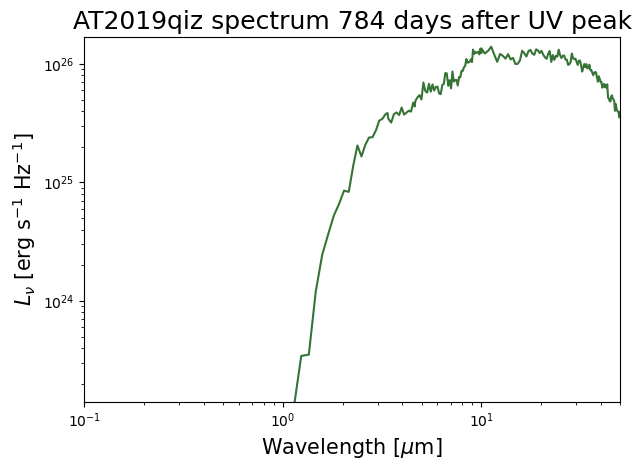

In [42]:
times=(np.array([54])) #Indices of the output times

fig=plt.figure()
ax=plt.subplot(111)

for t in range(len(times)):
#    color = thesis_cmap(times[t]/len(output_t)) # Get the color from the colormap
    color = thesis_cmap(30/len(output_t)) # Get the color from the colormap
#    ax.scatter(wavelengths, luminosity[times[t]],color=color,s=.8)
    ax.loglog(wavelengths, luminosity[times[t]],label=f'{int(output_t[times[t]])} after UV peak',color=color)

ax.set_xlabel(r'Wavelength [$\mu$m]',fontsize=15)
ax.set_ylabel(r'$L_{\nu}$ [erg s$^{-1}$ Hz$^{-1}$]',fontsize=15)
ax.set_ylim(bottom=np.max([luminosity[t].value for t in times])/1e3,top=np.max([luminosity[t].value for t in times])*1.2)

if len(times)>1:
    ax.set_title(f'{target} spectrum for different times')
    ax.legend()
else:
    ax.set_title(f'{target} spectrum {int(output_t[times])} days after UV peak',fontsize=18)

ax.set_xlim(0.1,np.max(wavelengths))
fig.tight_layout()
fig.savefig(PLOTFILES_+'/spectra.pdf',bbox_inches='tight')
plt.show()

### Making color-time diagrams

14/06/2024 18:53:02.425 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:306: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:53:02.425 !   m1 = -2.5*np.log(flux1.value/fzero_w1)
14/06/2024 18:53:02.426 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:307: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:53:02.426 !   m2 = -2.5*np.log(flux2.value/fzero_w2)
14/06/2024 18:53:02.426 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:309: RuntimeWarning: invalid value encountered in subtract
14/06/2024 18:53:02.426 !   return m1-m2


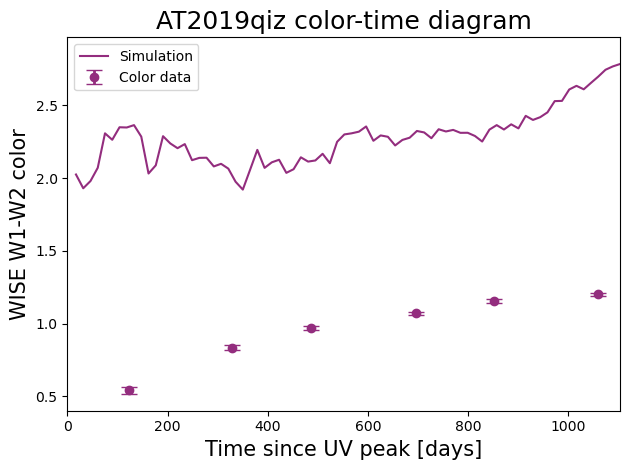

In [43]:
fig=plt.figure()
ax=plt.subplot(111)

ax.errorbar(W1_filtered[0], WISEcolor, yerr=WISEcolor_err, fmt='o', linewidth=2, capsize=6,label=f'Color data' , color=diff_col)
ax.plot(output_t,VegaColor(lightcurve_transmission('WISE_W1', wavelengths, luminosity),lightcurve_transmission('WISE_W2', output_wavelengths, luminosity),distance=distance),color=diff_col, label='Simulation')
#ax.scatter(output_t,VegaColor(lightcurve_transmission('WISE_W1', wavelengths, luminosity),lightcurve_transmission('WISE_W2', output_wavelengths, luminosity),distance=distance),color=diff_col,s=.8)

ax.set_xlim(0,np.max(output_t[:time_cutoff]))
#ax.set_ylim(np.min(WISEcolor)*0.8,np.max(WISEcolor)*1.2)

ax.set_xlabel(r'Time since UV peak [days]',fontsize=15)
ax.set_ylabel(r'WISE W1-W2 color',fontsize=15)
ax.set_title(target+' color-time diagram',fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig(PLOTFILES_+'color.pdf',bbox_inches='tight')
plt.show()

### Performing temperature analysis

14/06/2024 18:53:03.354 ! /usr/lib64/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in exp
14/06/2024 18:53:03.354 !   result = super().__array_ufunc__(function, method, *arrays, **kwargs)


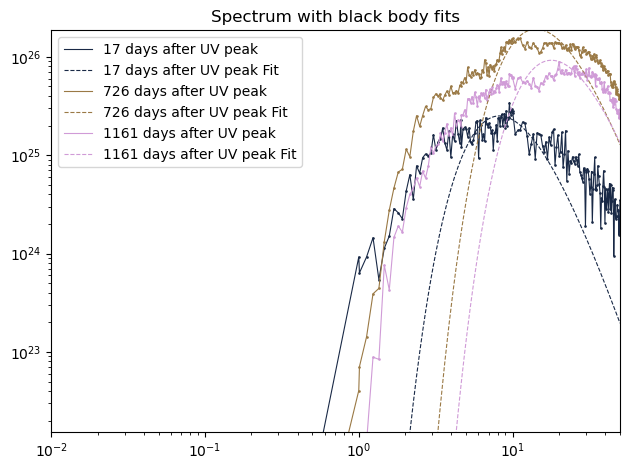

In [44]:
times=(np.array([1,50,80])) #Indices of the output times

p0 = (900,1e29)
bounds = ((200,1e25),(2e3,1e36))

fig=plt.figure()
ax=plt.subplot(111)

for t in range(len(times)):
    color = thesis_cmap(times[t]/len(output_t)) # Get the color from the colormap
    ax.scatter(wavelengths, luminosity[times[t]],color=color,s=.8)
    ax.loglog(wavelengths, luminosity[times[t]],label=f'{int(output_t[times[t]])} days after UV peak',color=color,linewidth=0.8)

    popt,pcov = curve_fit(bb_fit, wavelengths, luminosity[times[t]],p0=p0) # Finding best fit
    ax.loglog(wavelengths, bb_fit(wavelengths,popt[0],popt[1]),label=f'{int(output_t[times[t]])} days after UV peak Fit',color=color,linewidth=0.8,ls='--')

ax.set_ylim(bottom=np.max([luminosity[t].value for t in times])/1e4,top=np.max([luminosity[t].value for t in times])*1.2)
ax.set_xlim(np.min(wavelengths),np.max(wavelengths))

ax.set_title("Spectrum with black body fits")
plt.legend()
fig.tight_layout()
fig.savefig(PLOTFILES_+'/spectra.pdf')
plt.show()

#### Plotting the temperature and color

14/06/2024 18:53:17.641 ! /usr/lib64/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in exp
14/06/2024 18:53:17.641 !   result = super().__array_ufunc__(function, method, *arrays, **kwargs)
14/06/2024 18:53:22.767 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:306: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:53:22.767 !   m1 = -2.5*np.log(flux1.value/fzero_w1)
14/06/2024 18:53:22.767 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:307: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:53:22.767 !   m2 = -2.5*np.log(flux2.value/fzero_w2)
14/06/2024 18:53:22.768 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:309: RuntimeWarning: invalid value encountered in subtract
14/06/2024 18:53:22.768 !   return m1-m2


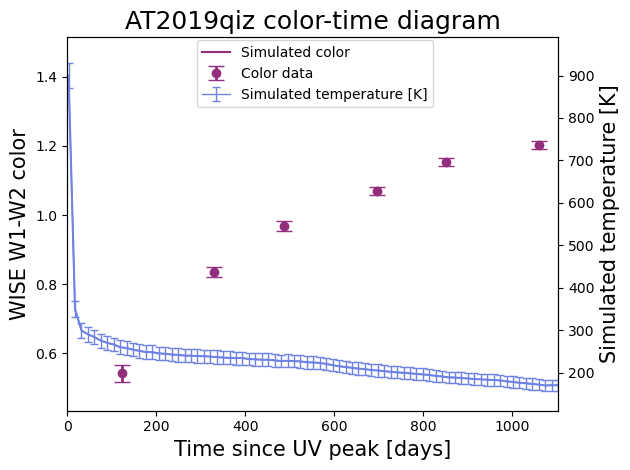

In [45]:
p0 = (900,1e29)
bounds = ((200,1e25),(2e3,1e36))

temperatures = []
temperature_errs = []
for t in range(len(output_t)):
    popt,pcov = curve_fit(bb_fit, wavelengths, luminosity[t],p0=p0) # Finding best fit
    temperatures.append(popt[0])    
    temperature_errs.append(np.sqrt(np.diag(popt))[0,0])

fig=plt.figure()
ax=plt.subplot(111)

ax.errorbar(W1_filtered[0], WISEcolor, yerr=WISEcolor_err, fmt='o', linewidth=2, capsize=6,label=f'Color data' , color=diff_col)
ax.plot(output_t,VegaColor(lightcurve_transmission('WISE_W1', wavelengths, luminosity),lightcurve_transmission('WISE_W2', output_wavelengths, luminosity),distance=distance),color=diff_col, label='Simulated color')
#ax.scatter(output_t,VegaColor(lightcurve_transmission('WISE_W1', wavelengths, luminosity),lightcurve_transmission('WISE_W2', output_wavelengths, luminosity),distance=distance),color=diff_col,s=.8)

ax2=ax.twinx()
ax2.errorbar(output_t,temperatures,yerr=temperature_errs,c='#6f83e3', linewidth=1, capsize=3,label='Simulated temperature [K]' )
ax2.plot(output_t,temperatures,c='#6f83e3')

ax.set_xlim(0,np.max(output_t[:time_cutoff]))
ax.set_ylim(np.min(WISEcolor)*0.8,np.max(WISEcolor)*1.2)
ax2.set_ylim(np.min(temperatures)*.9,np.max(temperatures)*1.1)

ax.set_xlabel(r'Time since UV peak [days]',fontsize=15)
ax.set_ylabel(r'WISE W1-W2 color',fontsize=15)
ax2.set_ylabel('Simulated temperature [K]',fontsize=15)
ax.set_title(target+' color-time diagram',fontsize=18)
#fig.legend(bbox_to_anchor=(.63,.25))
fig.legend(loc='upper center',bbox_to_anchor=(.5,.92))
fig.tight_layout()
plt.savefig(PLOTFILES_+'color_temp.pdf',bbox_inches='tight')
plt.show()

## For changing parameters

In [46]:
file_loc = '/ex/am/ple' #File location of the folder in which your data is located. Without a / on the end
var_values = [] # Values of the variable for which you did a run
var_name = 'Eg' # Name under which the variable's runs are saved
var_unit = None

luminosities_dict = {}
for i in var_values:
    luminosities_dict[i]=np.genfromtxt(file_loc+str(f'/{var_name}={i}/luminosity_data.txt'),delimiter = ' ') * u.erg/u.Hz/u.s
wavelengths = np.genfromtxt(file_loc+str(f'/{var_name}={var_values[0]}/wavelengths.txt'),delimiter = ' ')
output_t = np.genfromtxt(file_loc+str(f'/{var_name}={var_values[0]}/output_times.txt'),delimiter = ' ')

PLOTFILES_ = PLOTFILES+'old_data'+var_name+'/'
if os.path.isdir(PLOTFILES_) == False:
    os.makedirs(PLOTFILES_[:-1])

### Finding the covering factors

In [47]:
coveringFactors = []
for i, v in enumerate(var_values):
    coveringFactors.append(np.max(W1_filtered[1]*u.erg/u.s/u.Hz)/lightcurve_transmission('WISE_W1', wavelengths, luminosities_dict[v])[np.argmin(np.abs(output_t-W1_filtered[0,np.argmax(W1_filtered[1])]))])

    print(f"The covering factor for {str(var_name)}={str(v)} is {str(coveringFactors[i])} .")

The covering factor for Si=0.0 is 150.2083185985861 .
The covering factor for Si=0.1 is 54.54501910087353 .
The covering factor for Si=0.2 is 73.88574650157192 .
The covering factor for Si=0.3 is 67.22704360163257 .
The covering factor for Si=0.4 is 130.27701846684513 .
The covering factor for Si=0.5 is 42.355440656791906 .
The covering factor for Si=0.6 is 97.15511515605992 .
The covering factor for Si=0.7 is 53.95500876008622 .
The covering factor for Si=0.8 is 27.11538780961906 .
The covering factor for Si=0.9 is 17.089813518401648 .
The covering factor for Si=1.0 is 17.72322960255685 .


### Making Light curves

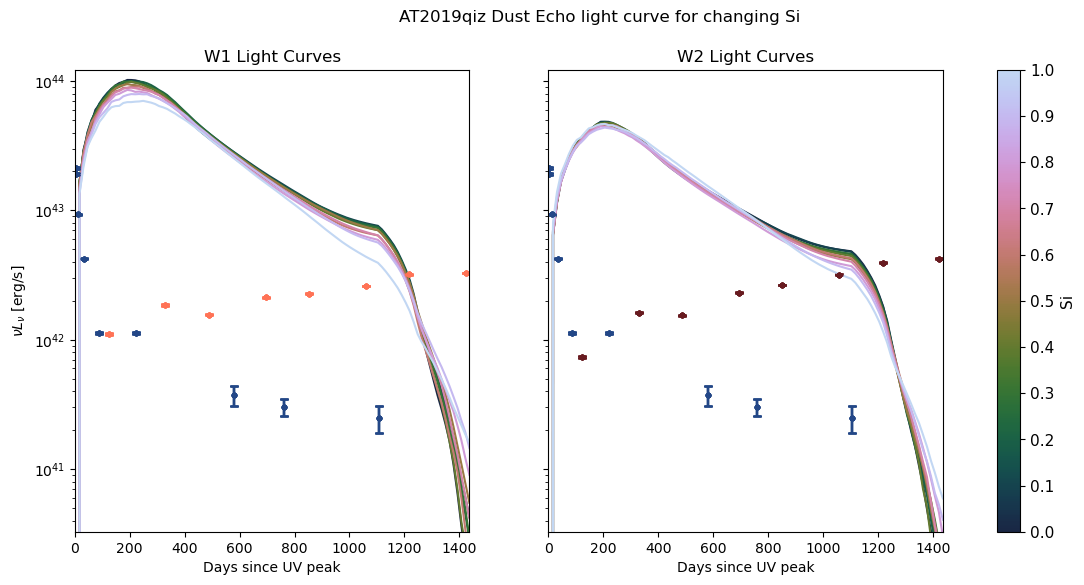

In [48]:
# Decide if you want to plot with covering factor and/or the data
cover = False
data = True

# Defining the nu_Lnu from the simulations, using the transmission curve
nu_Lnu_w1s = np.array([((c.c/wl_w1)*lightcurve_transmission('WISE_W1', wavelengths, luminosities_dict[v])).to(u.erg/u.s) for v in var_values])
nu_Lnu_w2s = np.array([((c.c/wl_w2)*lightcurve_transmission('WISE_W2', wavelengths, luminosities_dict[v])).to(u.erg/u.s) for v in var_values])

# Normalize the variable's values for the color mapping. 
# Can choose log or linear depending on the situation.
#norm = colors.LogNorm(vmin=min(var_values), vmax=max(var_values))
norm = colors.Normalize(vmin=min(var_values), vmax=max(var_values))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

for i in range(len(var_values)):
    color = thesis_cmap(norm(var_values[i]))
    if cover:
        ax1.plot(output_t, coveringFactors[i]*nu_Lnu_w1s[i], color = color)
        ax2.plot(output_t, coveringFactors[i]*nu_Lnu_w2s[i], color = color)
        fig.suptitle(target + f' Dust Echo light curve for changing {var_name} with covering factor')
        
    else:
        ax1.plot(output_t, nu_Lnu_w1s[i], color = color)
        ax2.plot(output_t, nu_Lnu_w2s[i], color = color)
        fig.suptitle(target + f' Dust Echo light curve for changing {var_name}')
        
    if data:
        ax1.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color=W1_col)
        ax1.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color=UV_col,capsize=3,label='UV-SWIFT/UVW1')
        ax2.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color=W2_col)
        ax2.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color=UV_col,capsize=3,label='UV-SWIFT/UVW1')


ax1.set_xlim(0,np.max(output_t))
ax1.set_xlabel('Days since UV peak')

if data:
    ax1.set_ylim(bottom=(c.c/wl_w1).to(u.Hz).value*np.max(W1[1])/1e2,top=np.max((np.append((nu_Lnu_w1s)*1.2, np.max(L_data[1])*1.2))))
else:
    ax1.set_ylim(bottom=np.max(nu_Lnu_w2.value)/1e2, top=np.max(nu_Lnu_w1.value)*1.2)
ax1.set_yscale('log')
ax1.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax1.set_title('W1 Light Curves')

ax2.set_xlabel('Days since UV peak')
ax2.set_xlim(0,np.max(output_t))
ax2.set_title('W2 Light Curves')

# Making the colorbar
sm = ScalarMappable(cmap=thesis_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='vertical')
tick_values = var_values
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)

if var_unit != None:
    cbar.set_label(str(var_name)+f' [{var_unit}]', fontsize=11)
else:
    cbar.set_label(str(var_name), fontsize=11)

if cover and data:
    fig.savefig(PLOTFILES + '/Lightcurve_cov_data.pdf')
elif cover and not data:
    fig.savefig(PLOTFILES_ + '/Lightcurve_cov.pdf')    
elif data and not cover:
    fig.savefig(PLOTFILES_ + '/Lightcurve_data.pdf')
else:
    fig.savefig(PLOTFILES_ + '/Lightcurve.pdf')
plt.show()

### Making spectra

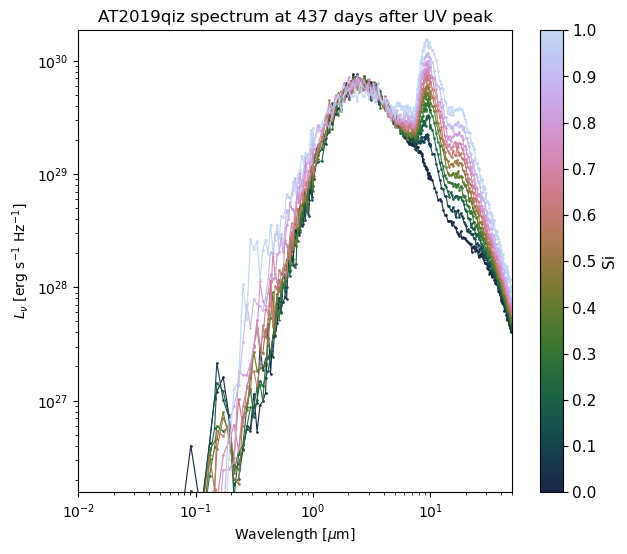

In [49]:
time_idx = 30 # Index of the time at which you want to show the spectra
fig,ax = plt.subplots(1,1,figsize=(7,6))

# Normalize the variable's values for the color mapping. 
# Can choose log or linear depending on the situation.
#norm = colors.LogNorm(vmin=min(var_values), vmax=max(var_values))
norm = colors.Normalize(vmin=min(var_values), vmax=max(var_values))

for v in var_values:
    color = thesis_cmap(norm(v))
    ax.loglog(wavelengths, luminosities_dict[v][time_idx], c=color, linewidth=.8)
    ax.scatter(wavelengths, luminosities_dict[v][time_idx], color=color, s=.8)

# Make the colorbar
sm = ScalarMappable(cmap=thesis_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
tick_values = var_values
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)

if var_unit != None:
    cbar.set_label(str(var_name)+f' [{var_unit}]', fontsize=11)
else:
    cbar.set_label(str(var_name), fontsize=11)

ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'$L_{\nu}$ [erg s$^{-1}$ Hz$^{-1}$]')
ax.set_ylim(bottom=np.max(np.array([luminosities_dict[v] for v in var_values])[:,time_idx])/1e4,top=np.max(np.array([luminosities_dict[v] for v in var_values])[:,time_idx])*1.2)

ax.set_title(f'{target} spectrum at {int(output_t[time_idx])} days after UV peak')
ax.set_xlim(np.min(wavelengths),np.max(wavelengths))
fig.savefig(PLOTFILES_+f'/spectra_{var_name}.pdf')
plt.show()

### Making color-time diagrams

14/06/2024 18:53:30.996 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:306: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:53:30.996 !   m1 = -2.5*np.log(flux1.value/fzero_w1)
14/06/2024 18:53:30.997 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:307: RuntimeWarning: divide by zero encountered in log
14/06/2024 18:53:30.997 !   m2 = -2.5*np.log(flux2.value/fzero_w2)
14/06/2024 18:53:30.998 ! /net/vdesk/data2/schoof_lankhorst/test/test2/utils.py:309: RuntimeWarning: invalid value encountered in subtract
14/06/2024 18:53:30.998 !   return m1-m2


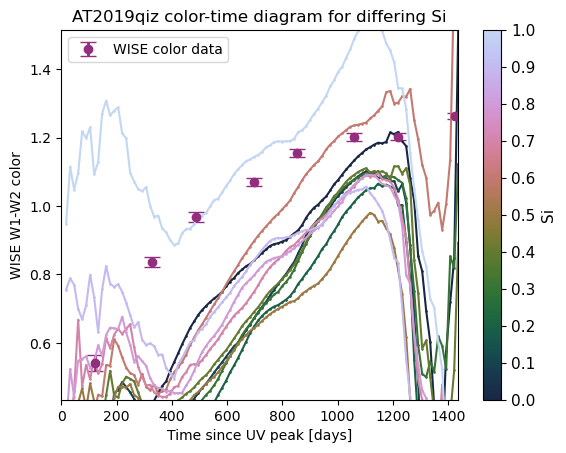

In [50]:
# Normalize the variable's values for the color mapping. 
# Can choose log or linear depending on the situation.
#norm = colors.LogNorm(vmin=min(var_values), vmax=max(var_values))
norm = colors.Normalize(vmin=min(var_values), vmax=max(var_values))

fig=plt.figure()
ax=plt.subplot(111)

ax.errorbar(W1_filtered[0], WISEcolor, yerr=WISEcolor_err, fmt='o', linewidth=2, capsize=6,label=f'WISE color data' , color=diff_col)

for v in var_values:
    color = thesis_cmap(norm(v))
    ax.plot(output_t,VegaColor(lightcurve_transmission('WISE_W1', wavelengths, luminosities_dict[v]),lightcurve_transmission('WISE_W2', wavelengths, luminosities_dict[v]),distance=distance),color=color)
    ax.scatter(output_t,VegaColor(lightcurve_transmission('WISE_W1', wavelengths, luminosities_dict[v]),lightcurve_transmission('WISE_W2', wavelengths, luminosities_dict[v]),distance=distance),color=color,s=.8)

# Make the colorbar
sm = ScalarMappable(cmap=thesis_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
tick_values = var_values
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)
if var_unit != None:
    cbar.set_label(str(var_name)+f' [{var_unit}]', fontsize=11)
else:
    cbar.set_label(str(var_name), fontsize=11)

ax.set_xlim(0,np.max(output_t))
ax.set_ylim(np.min(WISEcolor)*0.8,np.max(WISEcolor)*1.2)

ax.set_xlabel(r'Time since UV peak [days]')
ax.set_ylabel(r'WISE W1-W2 color')
ax.set_title(target+f' color-time diagram for differing {var_name}')
plt.legend()
plt.savefig(PLOTFILES_+'color.pdf')
plt.show()

### Performing a temperature analysis

14/06/2024 18:53:31.931 ! /usr/lib64/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in exp
14/06/2024 18:53:31.931 !   result = super().__array_ufunc__(function, method, *arrays, **kwargs)


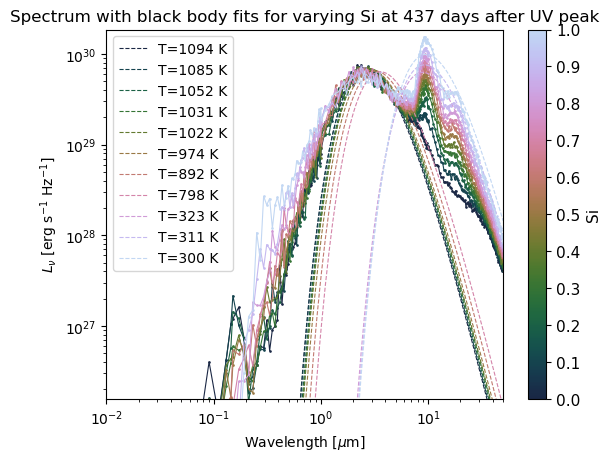

In [51]:
time_idx = 30 # Index of the time at which you want to show the spectra

# Normalize the variable's values for the color mapping. 
# Can choose log or linear depending on the situation.
#norm = colors.LogNorm(vmin=min(var_values), vmax=max(var_values))
norm = colors.Normalize(vmin=min(var_values), vmax=max(var_values))

p0 = (900,1e29)
bounds = ((200,1e25),(2e3,1e36))

fig=plt.figure()
ax=plt.subplot(111)

for v in var_values:
    color = thesis_cmap(norm(v))
    ax.scatter(wavelengths, luminosities_dict[v][time_idx],color=color,s=.8)
    ax.loglog(wavelengths, luminosities_dict[v][time_idx],color=color,linewidth=0.8)

    popt,pcov = curve_fit(bb_fit, wavelengths, luminosities_dict[v][time_idx],p0=p0) # Finding best fit
    ax.loglog(wavelengths, bb_fit(wavelengths,popt[0],popt[1]),color=color,linewidth=0.8,ls='--',label=f'T={int(popt[0])} K')

# Make the colorbar
sm = ScalarMappable(cmap=thesis_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
tick_values = var_values
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)
if var_unit != None:
    cbar.set_label(str(var_name)+f' [{var_unit}]', fontsize=11)
else:
    cbar.set_label(str(var_name), fontsize=11)

ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'$L_{\nu}$ [erg s$^{-1}$ Hz$^{-1}$]')
ax.set_ylim(bottom=np.max(np.array([luminosities_dict[v] for v in var_values])[:,time_idx])/1e4,top=np.max(np.array([luminosities_dict[v] for v in var_values])[:,time_idx])*1.2)
ax.set_xlim(np.min(wavelengths),np.max(wavelengths))
ax.set_title(f"Spectrum with black body fits for varying {var_name} at {int(output_t[time_idx])} days after UV peak")
plt.legend()
fig.savefig(PLOTFILES_+'/spectra_blackbodyfits.pdf')
plt.show()

#### Plotting the temperature and color

In [52]:
p0 = (900,1e29)
bounds = ((200,1e25),(2e3,1e36))

sim_temperatures = []

for v in var_values:
    temp_temp = []
    for t in range(len(output_t)):
        popt,pcov = curve_fit(bb_fit, wavelengths, luminosities_dict[v][t],p0=p0) # Finding best fit
        temp_temp.append(popt[0])
    sim_temperatures.append(temp_temp)
    
# Normalize the variable's values for the color mapping. 
# Can choose log or linear depending on the situation.
#norm = colors.LogNorm(vmin=min(var_values), vmax=max(var_values))
norm = colors.Normalize(vmin=min(var_values), vmax=max(var_values))

fig=plt.figure()
ax=plt.subplot(111)

ax.errorbar(W1_filtered[0], WISEcolor, yerr=WISEcolor_err, fmt='o', linewidth=2, capsize=6,label=f'Color data' , color=diff_col)
for v in var_values:
    color = thesis_cmap(norm(v))
    ax.plot(output_t,VegaColor(lightcurve_transmission('WISE_W1', wavelengths, luminosities_dict[v]),lightcurve_transmission('WISE_W2', wavelengths, luminosities_dict[v]),distance=distance),color=color, label='Color' if i==0 else '')
    ax.scatter(output_t,VegaColor(lightcurve_transmission('WISE_W1', wavelengths, luminosities_dict[v]),lightcurve_transmission('WISE_W2', wavelengths, luminosities_dict[v]),distance=distance),color=color,s=.8)
    ax.plot([0,1],[0,1],color=color, ls='dotted', label='Temperature [K]')
    
ax2=ax.twinx()
for i in range(len(sim_temperatures)):
    color = thesis_cmap(norm(var_values[i]))
    ax2.plot(output_t,sim_temperatures[i],c=color,label='Temperature [K]',ls='dotted')

# Make the colorbar
sm = ScalarMappable(cmap=thesis_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical',pad=0.1)
tick_values = var_values
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)
if var_unit != None:
    cbar.set_label(str(var_name)+f' [{var_unit}]', fontsize=11)
else:
    cbar.set_label(str(var_name), fontsize=11)

ax.set_xlim(0,np.max(output_t))
ax.set_ylim(np.min(WISEcolor)*0.8,np.max(WISEcolor)*1.2)
ax2.set_ylim(np.min(sim_temperatures)*.9,np.max(sim_temperatures)*1.1)

ax.set_xlabel(r'Time since UV peak [days]')
ax.set_ylabel(r'WISE W1-W2 color')
ax2.set_ylabel('Simulated temperature [K]')
ax.set_title(target+' color- and temperature-time diagram')
#fig.legend(bbox_to_anchor=(.63,.25))
ax.legend()
plt.savefig(PLOTFILES_+'color_temp.pdf')
plt.show()

14/06/2024 18:53:33.642 ! /usr/lib64/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in exp
14/06/2024 18:53:33.642 !   result = super().__array_ufunc__(function, method, *arrays, **kwargs)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

# The end :)